# Influencia de variables adicionales en la predicción de los niveles de glucosa en sangre.

Trabajo de Finalización de Máster en Inteligencia Artificial en la [Universidad Internacional de la Rioja (UNIR)](https://unir.net)

Realizado por [Xavi Coret Mayoral](https://xcoret.github.io/portfolio/)

El conjunto de datos utilizado ("Glucose_measurements_sample.csv") ha sido proporcionado por el director de este Trabajo de Fin de Máster, Ciro Rodríguez León.

## Instalación e importación de librerías necesarias

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Sequential
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout, BatchNormalization,CuDNNLSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



## Definición de constantes

In [2]:
# Etiquetas de los meses del año
MONTH_TAGS = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
# Etiquetas de los dias de la semana
WEEKDAY_TAGS = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
# Etiquetas de los momentos del dia
# DAYTIME_TAGS = ['Madrugada','Mañana','Mediodía','Tarde','Anochecer','Noche']
DAYTIME_TAGS = ['Madrugada','Mañana','Tarde','Noche']
# Etiquetas de tendencia
TREND_TAGS = ['Igual', 'Creciente', 'Decreciente']
# Etiquetas de diagnostico
HEALTHY_RANGE = [70,180] # https://doi.org/10.2337/dc22-S006
DIAGNOSTIC_TAGS = ['En rango','Por encima de rango','Por debajo de rango']

# Columnas del DataFrame
INITIAL_COLUMNS = ['Patient_ID',
                'Measurement_date',
                'Measurement_time',
                'Measurement'
]

FINAL_COLUMNS =['Patient_ID',
                'Measurement_date',
                'Measurement_time',                
                'Difference',
                'Trend',
                'Diagnostic',
                'Measurement_datetime',
                'Time_diff',
                'Unix_datetime',
                'Year',
                'Month',
                'Day',
                'Weekday',
                'Hour',
                'Minute',
                'Daytime',
                'Measurement'
]
TARGET_FEATURE = 'Normalized_Measurement'

# Carpeta de destino de los recursos generados
OUTPUT_FOLDER = os.path.join(os.getcwd(),'Output')
DATA_FOLDER = os.path.join(os.getcwd(),'Data')
MODELS_FOLDER = os.path.join(DATA_FOLDER,'Models')
# Capeta de destino del dataframe de series temporales
TIME_SERIES_PATH = os.path.join(DATA_FOLDER,"Glucose_Time_Series.csv")
PREDICTIONS_PATH = os.path.join(DATA_FOLDER,"Predictions_test.csv")
SUMMARY_PATH = os.path.join(DATA_FOLDER,"Summary.csv")

# Crear en caso que no exista previamente
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)
if not os.path.exists(MODELS_FOLDER):
    os.makedirs(MODELS_FOLDER)

# Color azul UNIR
UNIR_COLOR = '#0098CD'

# Longitud de las secuencias temporales
SEQUENCE_LENGTH = 12

# Rango de tiempo permitido entre los registros de una misma secuencia
TIME_DIFF_RANGE = [14,15,16]

# Definir el modo de representación de los valores en Pandas
pd.set_option('display.float_format', '{:.5f}'.format)

# Tamaño del conjunto de training sobre el conjunto de datos completo
TRAIN_RATIO = 0.80
# Tamaño del conjunto de test sobre el conjunto de datos completo
TEST_RATIO = 0.20
# Tamaño del conjunto de validacion sobre el conjunto test
VALIDATION_RATIO = 0.5
# Instanciar SCALER para normalizar los datos entre 0 y 1
SCALER = MinMaxScaler()

# Etiquetas de las zonas de la rejilla de errores de Clarke
ZONE_LABELS = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

EPOCHS = 10
BATCH_SIZE = 128

ZONE_DESCRIPTIONS = {
    'A': "dentro del 20% del sensor de referencia",
    'B': "fuera del 20% pero no conduciría a un tratamiento inapropiado",
    'C': "que indican un tratamiento innecesario",
    'D': "que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia",
    'E': "que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa"
}

pd.options.mode.chained_assignment = None  # default='warn'

## Definición de funciones

### Número de mediciones por paciente

In [3]:
def measurementsPerPatient(dataframe):
    unique_values = dataframe['Patient_ID'].unique()
    print('Número de pacientes: {}'.format(len(unique_values)))
    examples_per_patient = dataframe['Patient_ID'].value_counts()
    plt.figure(figsize=(20, 6))
    plt.bar(examples_per_patient.index, examples_per_patient.values, color=UNIR_COLOR)
    plt.title('Número de mediciones por paciente')
    plt.xlabel('Paciente')
    plt.ylabel('Número de mediciones')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.xlim(-0.6, len(examples_per_patient) - 0.6)
    plt.show()

### Número de mediciones por año

In [4]:
def measurementPerYear(dataframe):
    temp_df = dataframe.copy()
    temp_df['Measurement_date'] = pd.to_datetime(temp_df['Measurement_date'])
    print('Fecha del primer registro: {}\nFecha del último registro {}'.format(str(temp_df['Measurement_date'].min()).split(' ')[0],str(temp_df['Measurement_date'].max()).split(' ')[0]))
    year_counts = temp_df['Measurement_date'].dt.year.value_counts()
    plt.figure(figsize=(8, 6))
    plt.bar(year_counts.index, year_counts.values, color=UNIR_COLOR)
    plt.xlabel('Año')
    plt.ylabel('Número de mediciones')
    plt.grid(True)
    plt.title('Número de mediciones por año')
    for i, value in enumerate(year_counts.values):
        plt.text(year_counts.index[i], value, str(value), ha='center', va='bottom')
    plt.show()

### Número de mediciones por mes

In [5]:
def monthlyMeasurement(dataframe):
    temp_df = dataframe.copy()
    temp_df['Measurement_date'] = pd.to_datetime(temp_df['Measurement_date'])
    month_counts = temp_df['Measurement_date'].dt.month.value_counts()
    plt.figure(figsize=(8, 6))
    plt.bar(month_counts.index, month_counts.values, color=UNIR_COLOR)
    plt.xlabel('Mes')
    plt.ylabel('Número de mediciones')
    plt.grid(True)
    plt.title('Número de mediciones por mes')
    plt.xticks(range(1, 13), [MONTH_TAGS[x-1] for x in range(1, 13)],rotation='vertical')
    for i, value in enumerate(month_counts.values):
        plt.text(month_counts.index[i], value, str(value), ha='center', va='bottom')
    plt.show()

### Número de mediciones por mes y año

In [6]:
def monthlyMeasurementPerYear(dataframe):
    plt.figure(figsize=(12, 6))
    temp_df = dataframe.copy()
    temp_df['Measurement_date'] = pd.to_datetime(temp_df['Measurement_date'])    
    years = temp_df['Measurement_date'].dt.year.unique()
    years_sorted = sorted(years)  
    for year in years_sorted:
        year_data = temp_df[temp_df['Measurement_date'].dt.year == year]
        month_counts = year_data['Measurement_date'].dt.month.value_counts().sort_index()
        plt.plot(month_counts.index, month_counts.values, marker='o', label=str(year))
    plt.xlabel('Mes')
    plt.ylabel('Número de mediciones')
    plt.title('Número de mediciones por mes y año')
    plt.grid(True)
    plt.xticks(range(1, 13), [MONTH_TAGS[x-1] for x in range(1, 13)], rotation='vertical')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

### Número de mediciones por dia de la semana

In [7]:
def weekdayMeasurement(dataframe):
    weekday_means = []    
    for weekday in range(len(WEEKDAY_TAGS)):
        sample = dataframe[dataframe['Weekday']==weekday]
        weekday_means.append(round(sample['Measurement'].describe()['mean'],2))
    plt.figure(figsize=(8,6))
    plt.plot(WEEKDAY_TAGS,weekday_means, color=UNIR_COLOR)
    plt.xlabel('Día de la semana')
    plt.ylabel('Media del nivel de glucosa')
    plt.title('Media del nivel de glucosa por día de la semana')    
    for i,mean in enumerate(weekday_means):
        plt.text(i,mean,str(mean),ha='center',va='bottom')
    plt.show()

### Número de mediciones por momento del dia

In [8]:
def daytimeMeasurement(dataframe):
    daytime_means = []
    for daytime in range(len(DAYTIME_TAGS)):
        sample = dataframe[dataframe['Daytime']==daytime]
        daytime_means.append(round(sample['Measurement'].describe()['mean'],2))    
    plt.figure(figsize=(8, 6))
    plt.plot(DAYTIME_TAGS, daytime_means, marker='o', color=UNIR_COLOR)
    plt.xlabel('Momento del día')
    plt.ylabel('Media del nivel de glucosa')
    plt.title('Media del nivel de glucosa por momento del día')
    for i, mean in enumerate(daytime_means):
        plt.text(i, mean, str(mean), ha='center', va='bottom')
    plt.show()

### Crear matriz de correlación de Pearson

In [9]:
def plotCorrelation(dataframe, columns_order,name):
    dataframe.reindex(columns=columns_order)
    dataframe = dataframe.drop('Patient_ID', axis=1)
    dataframe['Measurement_date'] = pd.to_datetime(dataframe['Measurement_date'])
    dataframe['Measurement_time'] = pd.to_datetime(dataframe['Measurement_time'])
    correlation_matrix = dataframe.corr()
    measurement_correlation = dataframe.corr()['Measurement']
    correlation_matrix_filled = correlation_matrix.copy()
    correlation_matrix_filled['Measurement'] = measurement_correlation
    correlation_matrix_filled.loc['Measurement'] = measurement_correlation
      
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_filled, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Matriz de Correlación de Pearson del conjunto de datos {}".format(name))
    plt.tight_layout() 
    plt.savefig(os.path.join(OUTPUT_FOLDER, 'pearson_{}.png'.format(name))) 
    plt.show()

### Crear gfráficas del entrenamiento

In [10]:
def plotTraining(model_name,history): 
    train_loss = history['loss']
    val_loss = history['val_loss']
    plt.figure(figsize=(8,6))
    plt.plot(train_loss, label='Entrenamiento ', marker='o', color=UNIR_COLOR)
    plt.plot(val_loss, label='Validación', marker='o', color='#FF6732')
    plt.title('Pérdida (MSE) en Entrenamiento y Validación Loss\n{}'.format(model_name))
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.legend()

    min_train_loss = min(train_loss)
    max_train_loss = max(train_loss)
    min_val_loss = min(val_loss)
    max_val_loss = max(val_loss)

    pad = 0.00002
    plt.text(train_loss.index(min_train_loss), min_train_loss+pad, '{:.4f} min E'.format(min_train_loss), ha='center', va='bottom', color=UNIR_COLOR)
    plt.text(train_loss.index(max_train_loss), max_train_loss+pad, '{:.4f} max E'.format(max_train_loss), ha='center', va='bottom', color=UNIR_COLOR)
    
    plt.text(val_loss.index(min_val_loss), min_val_loss-pad, '{:.4f} min V'.format(min_val_loss), ha='center', va='top', color='#FF6732')
    plt.text(val_loss.index(max_val_loss), max_val_loss-pad, '{:.4f} max V'.format(max_val_loss), ha='center', va='top', color='#FF6732')

    # Adjust the y-axis limits
    plt.ylim(min(min_train_loss, min_val_loss)-0.0001, max(max_train_loss, max_val_loss)+0.0001)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FOLDER, 'training_{}.png'.format(model_name))) 
    plt.show()

### Rejilla de error de Clarke (adaptada)

In [11]:
'''
DISCLAIMER:
La función 'clarke_error_grid' ha sido recopilada del GitHub de Trevor Tsue y adaptada para la representación del trabajo actual
# https://github.com/suetAndTie/ClarkeErrorGrid/blob/master/ClarkeErrorGrid.py

'''

def clarke_error_grid(ref_values, pred_values, model_name):
    # Comprobando si las longitudes de los arrays de referencia y predicción son iguales
    assert (len(ref_values) == len(pred_values)), "Número desigual de valores (referencia: {}) (predicción: {}).".format(len(ref_values), len(pred_values))
    # Limpiar el gráfico
    plt.clf()
    plt.figure(figsize=(8, 8))
    # Configurar el gráfico
    plt.scatter(ref_values, pred_values, marker='o', color='#0098CD', s=8, alpha=0.25)
    plt.title(model_name + " Gráfico de Error de Clarke")
    plt.xlabel("Concentración de Referencia (mg/dl)")
    plt.ylabel("Concentración de Predicción (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])
    plt.gca().set_facecolor('white')

    # Establecer las longitudes de los ejes
    plt.gca().set_xlim([0, 550])
    plt.gca().set_ylim([0, 550])
    plt.gca().set_aspect((400)/(400))

    plt.plot([0, 550], [0, 550], ':', c='black')  # Línea de regresión teórica de 45 grados
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    plt.plot([175/3, 550/1.2], [70, 550], '-', c='black')  # Reemplazar 320 con 400/1.2 porque 100*(400 - 400/1.2)/(400/1.2) =  20% de error
    plt.plot([70, 70], [84, 550], '-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 440], [180, 550], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')  # Reemplazar 175.3 con 56 porque 100*abs(56-70)/70) = 20% de error
    plt.plot([70, 550], [56, 440], '-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 550], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180], '-', c='black')
    plt.plot([240, 550], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    # Agregar títulos de zonas
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)
    plt.grid(True)

    # Estadísticas de los datos
    zone = [0] * 5
    zones = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2 * ref_values[i] and pred_values[i] >= 0.8 * ref_values[i]):
            zone[0] += 1  # Zona A
            zones['A'] += 1
        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1  # Zona E
            zones['E'] += 1
        elif ((ref_values[i] >= 70 and ref_values[i] <= 440) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7 / 5) * ref_values[i] - 182)):
            zone[2] += 1  # Zona C
            zones['C'] += 1
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175 / 3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175 / 3 and ref_values[i] <= 70) and pred_values[i] >= (6 / 5) * ref_values[i]):
            zone[3] += 1  # Zona D
            zones['D'] += 1
        else:
            zone[1] += 1  # Zona B
            zones['B'] += 1


    plt.savefig(os.path.join(OUTPUT_FOLDER, 'clarke_{}.png'.format(model_name))) 
    return plt, zones



### Añadir variables extraidas

In [12]:
def addAdditionalVariables(dataframe, verbose=False):
    # Concatenar fecha y hora
    dataframe['Measurement_datetime'] = pd.to_datetime(dataframe['Measurement_date'] + ' ' + dataframe['Measurement_time'])


    print('Añadiendo variables inferidas de la medición:\n\t"Difference", "Trend", "Diagnostic"')
    # Convierte la columna "Measurement" a tipo numérico
    dataframe["Measurement"] = pd.to_numeric(dataframe["Measurement"], errors="coerce")

    # Ordena el DataFrame por fecha y hora dentro de cada paciente
    dataframe = dataframe.groupby("Patient_ID", group_keys=False).apply(lambda x: x.sort_values(["Measurement_datetime"]))

    # Calcula la diferencia de medición entre registros consecutivos para cada paciente
    dataframe["Difference"] = dataframe.groupby("Patient_ID", group_keys=False)["Measurement"].diff().fillna(0)
    dataframe['Difference'] = pd.to_numeric(dataframe['Difference']).astype(int)

    # Calcula la tendencia de la medición (1 para diferencia positiva, -1 para diferencia negativa, 0 para ninguna diferencia)
    dataframe['Trend'] = np.sign(dataframe['Difference']).astype(int)

    # Definir diagnostico según nivel de glucosa (1 para Hiperglucemia (más de 130), -1 para Hipoglucemia (menos de 70), 0 para nivel de glucemia controlado)
    dataframe['Diagnostic'] = np.where((dataframe['Measurement'] > HEALTHY_RANGE[1]), 1,np.where((dataframe['Measurement'] < HEALTHY_RANGE[0]), -1, 0)).astype(int)
    print('Añadiendo variables inferidas de la fecha:\n\t"Year", "Month", "Day", "Weekday"')

    # Extrae componentes de fecha
    dataframe['Year'] = dataframe['Measurement_datetime'].dt.year
    dataframe['Month'] = dataframe['Measurement_datetime'].dt.month
    dataframe['Day'] = dataframe['Measurement_datetime'].dt.day

    # Calcula el día de la semana según la fecha
    dataframe['Weekday'] = dataframe['Measurement_datetime'].dt.weekday
    print('Añadiendo variables inferidas de la hora:\n\t"Hour", "Minute", "Daytime"')

    # Extrae componentes de tiempo
    dataframe['Hour'] = dataframe['Measurement_datetime'].dt.hour
    dataframe['Minute'] = dataframe['Measurement_datetime'].dt.minute

    # Etiqueta el momento del día

    # DAYTIME_TAGS = ['0-4', '4-10', '10-13', '13-18', '18-22', '22-24']
    # dataframe['Daytime'] = pd.cut(dataframe['Hour'], bins=[-1, 4, 10, 13, 18, 22, 24], labels=np.arange(len(DAYTIME_TAGS))).astype(int)
    dataframe['Daytime'] = pd.cut(dataframe['Hour'], bins=[-1, 6, 12, 19, 24], labels=np.arange(len(DAYTIME_TAGS))).astype(int)
    print('Añadiendo fecha y hora en formato Unix:\n\t"Unix_datetime"')

    # Convierte la fecha y hora a formato Unix como identificador de tiempo para secuencias temporales
    dataframe['Unix_datetime'] = dataframe['Measurement_datetime'].apply(lambda x: int(x.timestamp()))
    print('Añadiendo diferencia de tiempo entre registros anteriores por paciente:\n\t"Time_diff"')
    dataframe['Time_diff'] = dataframe.groupby('Patient_ID', group_keys=False)['Measurement_datetime'].diff().dt.total_seconds()//60
    dataframe['Time_diff'].fillna(15,inplace=True)
    # Los NA corresponden al primer registro de cada paciente, por eso lo establecemos en 15 y asi no lo obviamos en posteriores procesamientos
    dataframe['Time_diff'] = dataframe['Time_diff'].astype(int)

 
    return dataframe.reindex(columns=FINAL_COLUMNS)

### Crear series temporales

In [13]:
# TODO: Tratar valores del primer registro despues de una secuencia eliminada (Diferencia de tiempo mayor a 15 min)

def createTemporalSeries(dataframe, verbose=False):
    print("Creando series temporales")
    dataframe = dataframe.reset_index(drop=True)
    # Crear diccionario vacio    
    valid_indexes = []
    # Agrupar los registros del conjunto de datos por paciente
    for patient_id, patient_data in dataframe.groupby("Patient_ID"):
        # print(patient_id, len(patient_data))
        current_sequence=[]
        for index, row in patient_data.iterrows():
            if row['Time_diff'] in TIME_DIFF_RANGE:
                # Comprobar longitud de la secuencia actual
                # Si la secuencia actual tiene 12 registros
                if len(current_sequence)==SEQUENCE_LENGTH:
                    # Guardar secuencia y añadir registro a nueva secuencia
                    valid_indexes.extend(current_sequence)
                    current_sequence=[]
                # Agregar indice a la secuencia actual
                current_sequence.append(index)
            else:
                current_sequence=[]

    return dataframe[dataframe.index.isin(valid_indexes)]

### Entreno de los modelos

In [14]:
def fitAndEvaluate(model,model_name,training_set,validation_set,test_set, epochs=10, batch_size=32):
    X_train,y_train = training_set
    X_validation,y_validation = validation_set
    X_test,y_test = test_set

    model_path = os.path.join(MODELS_FOLDER,'{}.h5'.format(model_name))
    history_path = model_path.replace('.h5','.pkl')

    if not os.path.exists(model_path):
        print("\nEmpezando el entrenamiento del modelo {}".format(model_name))
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size)        
        model.save(model_path)

        with open(history_path, 'wb') as history_file:
            pickle.dump(history.history, history_file)
        print('Modelo "{}" guardado en:\n\t{}\nHistorial de entrenamiento guardado en:\n\t{}'.format(model_name,model_path,history_path))
        history_data = history.history        
    else:
        print('\nEl modelo "{}" ya existe. \nCargando modelo e historial de entrenamiento.'.format(model_name))
        model = load_model(model_path)
        with open(history_path,'rb') as history_file:
            history_data = pickle.load(history_file)      
        
    plotTraining(model_name, history_data)

    print('\n==== Resultados de evaluación del modelo ====\n')
    loss = model.evaluate(X_test,y_test)
    print('Pérdida (MSE) : {}'.format(loss))

    y_pred = model.predict(X_test)


    y_pred = SCALER.inverse_transform(y_pred)
    y_test = SCALER.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print('\n==== Resultados de test ====\n')
    print('Error Cuadrático Medio (MSE): {}'.format(mse))
    print('Error Absoluto Medio (MAE): {}'.format(mae))
    print('Puntuación R^2: {}'.format(r2))  

    plot,zones = clarke_error_grid(y_test, y_pred, model_name)
    plot.show()
    for zone_label in zones:
        if zone_label in ZONE_DESCRIPTIONS:        
            print("Región {}: {} puntos {}".format(zone_label,zones[zone_label],ZONE_DESCRIPTIONS[zone_label]))
        else:        
            print("Región {}: {} puntos".format(zone_label,zones[zone_label]))
    print("Total casos: {}".format(len(y_pred)))

    return [loss,mse,mae,r2,y_pred] 

### Crear sets de entrenamiento, validación y prueba

In [15]:
def splitTrainValTest(dataframe, variables=['Measurement'],case=''):
    print("Creando conjuntos de Entrenamiento, Validación y Test")
    if 'Measurement' not in variables:
        variables.append('Measurement')

    for variable in variables:
        dataframe.loc[:, 'Normalized_{}'.format(variable)] = SCALER.fit_transform(dataframe[variable].values.reshape(-1, 1))

    norm_names = list(map(lambda x: 'Normalized_{}'.format(x), variables))
    new_dataframe = dataframe[norm_names].copy().reset_index(drop=True)
    # print(new_dataframe.head())

    sequences = []
    labels = []
    tags = 0
    k=0
    current_sequence = []
    for i, row in new_dataframe.iterrows():
        # print('{}[{}] : {}'.format(i,k,row['Normalized_Measurement']))        
        current_sequence.append(row.values.flatten().tolist())
        if (k%(SEQUENCE_LENGTH-1)==0 and k>0) or k==len(new_dataframe):
            # print('---SAVING LABEL {} AT INDEX {}'.format(row['Normalized_Measurement'],i))            
            k=0
            sequences.append(current_sequence)
            labels.append(row['Normalized_Measurement'])
            current_sequence = []
        else:
            k+=1

    print("Shape of sequences after split: ", np.array(sequences).shape)
    print("Shape of labels after split: ", np.array(labels).shape)

    print(sequences[0])
    print(labels[0])

        # X_train, X_temp, y_train, y_temp
    train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(sequences, labels, test_size=TEST_RATIO, random_state=12081995)
    # X_test, X_val, y_test, y_val
    test_sequences, val_sequences, test_labels, val_labels = train_test_split(temp_sequences, temp_labels, test_size=VALIDATION_RATIO, random_state=12081995)

    X_train,y_train = [train_sequences,train_labels]
    X_validation,y_validation = [val_sequences,val_labels]
    X_test,y_test = [test_sequences,test_labels]

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_validation = np.array(X_validation)
    y_validation = np.array(y_validation)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_train = X_train.reshape(X_train.shape[0], SEQUENCE_LENGTH, len(variables))
    X_validation = X_validation.reshape(X_validation.shape[0], SEQUENCE_LENGTH, len(variables))
    X_test=X_test.reshape(X_test.shape[0], SEQUENCE_LENGTH, len(variables))

    total_size = len(sequences)
    print("Secuencias totales: {} ({} registros)".format(total_size,total_size*SEQUENCE_LENGTH))
    train_percent = int(((total_size*TRAIN_RATIO)/total_size)*100)
    test_percent  = int((((total_size*TEST_RATIO)/total_size)*100)*0.5)
    val_percent   = test_percent

    print(X_train.shape)
    print(y_train.shape)

    print("Secuencias de entrenamiento: {} ({}%) - Etiquetas de entrenamiento: {}\nPrimera secuencia: \n{}\nEtiqueta: {}\n".format(len(X_train),train_percent,len(y_train),X_train[0].flatten(),y_train[0]))
    print("Secuencias de validación: {} ({}%) - Etiquetas de validación: {}\nPrimera secuencia: \n{}\nEtiqueta: {}\n".format(len(X_validation),val_percent,len(y_validation),X_validation[0].flatten(),y_validation[0])) 
    print("Secuencias de  prueba: {} ({}%) - Etiquetas de prueba: {}\nPrimera secuencia: \n{}\nEtiqueta: {}\n".format(len(X_test),test_percent,len(y_test),X_test[0].flatten(),y_test[0]))
    
    # with open(os.path.join(DATA_FOLDER,'{}.pkl'.format(case)),'wb') as bf:
    #     pickle.dump([(X_train, y_train),(X_validation, y_validation),(X_test, y_test),SCALER],bf)

    return [X_train,y_train],[X_validation,y_validation],[X_test,y_test]


### Run cases

In [16]:
def runCases(dataframe,cases_summary):
    optimizer = Adam(learning_rate=0.001,decay=1e-6)
    for case in cases_summary:
        variables = cases_summary[case][0]
        print('\n\n\n')
        print('\n{}\n===== {} =====\n{}\nVariables usadas: {}'.format('='*95,case,'='*95,variables))
        training_set,validation_set,test_set = splitTrainValTest(dataframe,variables, case)
        # if not os.path.exists(os.path.join(DATA_FOLDER,'{}.pkl'.format(case))):
        #     training_set,validation_set,test_set = splitTrainValTest(dataframe,variables, case)
        # else:
            
        #     print('Cargando conjuntos de entrenamiento, validación y prueba')
        #     with open(os.path.join(DATA_FOLDER,'{}.pkl'.format(case)),'rb')as bf:
        #         loaded_data = pickle.load(bf)
        #     training_set, validation_set, test_set,SCALER = loaded_data
        model_name = '{}{}_M1'.format(case[0],case[-1])
        print('{}\n==== Primer modelo ({}) ====\n{}'.format('='*16, model_name ,'='*16))

        model1 = Sequential()
        model1.add(CuDNNLSTM(units=128,input_shape=(SEQUENCE_LENGTH, len(variables))))
        model1.add(Dense(units=32, activation="linear"))
        model1.add(Dense(1,activation='linear'))
        model1.summary()
        plot_model(model1, to_file=os.path.join(OUTPUT_FOLDER,'{}_plot.png'.format(model_name)), show_shapes=True, show_layer_names=True)
        model1.compile(optimizer=optimizer,loss='mean_squared_error')
        cases_summary[case].append(fitAndEvaluate(model=model1,model_name=model_name.format(case),training_set=training_set,validation_set=validation_set,test_set=test_set, epochs=EPOCHS, batch_size=BATCH_SIZE))

        model_name = '{}{}_M2'.format(case[0],case[-1])
        print('{}\n==== Segundo modelo ({}) ====\n{}'.format('='*16, model_name ,'='*16))
        model2 = Sequential()
        model2.add(CuDNNLSTM(units=256,return_sequences=True,input_shape=(SEQUENCE_LENGTH, len(variables))))
        model2.add(Dropout(0.25))
        model2.add(CuDNNLSTM(128))
        model2.add(Dense(units=64, activation="linear"))
        model2.add(BatchNormalization())
        model2.add(Dropout(0.25))        
        model2.add(Dense(units=32, activation="linear"))
        model2.add(BatchNormalization())
        model2.add(Dropout(0.25))
        model2.add(Dense(1,activation='linear'))
        model2.summary()
        plot_model(model2, to_file=os.path.join(OUTPUT_FOLDER,'{}_plot.png'.format(model_name)), show_shapes=True, show_layer_names=True)
        model2.compile(optimizer=optimizer,loss='mean_squared_error')
        cases_summary[case].append(fitAndEvaluate(model=model2,model_name=model_name.format(case),training_set=training_set,validation_set=validation_set,test_set=test_set, epochs=EPOCHS, batch_size=BATCH_SIZE))
        
        model_name = '{}{}_M3'.format(case[0],case[-1])        
        model3 = Sequential()
        model3.add(CuDNNLSTM(units=128, input_shape=(SEQUENCE_LENGTH, len(variables))))
        model3.add(Dropout(0.2))
        model3.add(Dense(units=256, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=128, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=64, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=32, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=1, activation='linear'))
        model3.summary()
        plot_model(model3, to_file=os.path.join(OUTPUT_FOLDER,'{}_plot.png'.format(model_name)), show_shapes=True, show_layer_names=True)
        model3.compile(optimizer=optimizer, loss='mean_squared_error')
        cases_summary[case].append(fitAndEvaluate(model=model3,model_name=model_name.format(case),training_set=training_set,validation_set=validation_set,test_set=test_set, epochs=EPOCHS, batch_size=BATCH_SIZE))

    data = []
    prediction_results = [SCALER.inverse_transform(test_set[1].reshape(-1, 1))]
    predictions_columns = ['y_test']
    for case in cases_summary:
        variables= cases_summary[case][0]
        for i,model in enumerate(cases_summary[case][1:]):            
            loss,mse,mae,r2,y_pred = model
            data.append([case,"Model {}".format(i+1),mse,mae,r2])
            prediction_results.append(y_pred)
            predictions_columns.append('{}_Model{}'.format(case,i+1))

    summary_columns = ['Case', 'Model', 'mse','mae','r2']
    df_summary = pd.DataFrame(data, columns=summary_columns)
    df_summary['rmse'] = np.sqrt(df_summary['mse'])
    df_summary.to_csv(SUMMARY_PATH,index=False)

    reshaped_prediction_results = [np.reshape(arr, (-1,)) for arr in prediction_results]
    transposed_prediction_results = np.transpose(reshaped_prediction_results)
    df_prediction_results = pd.DataFrame(data=transposed_prediction_results, columns=predictions_columns)
    df_prediction_results.to_csv(PREDICTIONS_PATH,index=False)
    return df_summary
        

In [17]:
def plotMetricsAnalisys():
    data = pd.read_csv(SUMMARY_PATH)
    # Obtener la lista de casos y modelos únicos
    casos = data['Case'].unique()
    modelos = data['Model'].unique()

    # Configuración de la figura y subplots
    fig, axes = plt.subplots(len(casos), len(modelos), figsize=(15, 15))
    fig.suptitle('Comparación de métricas por caso y modelo', fontsize=16)

    for i, caso in enumerate(casos):
        for j, modelo in enumerate(modelos):
            # Filtrar los datos por caso y modelo
            datos_filtrados = data[(data['Case'] == caso) & (data['Model'] == modelo)]

            if not datos_filtrados.empty:
                # Obtener las métricas correspondientes
                mse = datos_filtrados['mse'].values[0]
                mae = datos_filtrados['mae'].values[0]
                r2 = datos_filtrados['r2'].values[0]

                # Graficar las métricas correspondientes en el subplot correspondiente
                metrics = ['MSE', 'MAE', 'R^2']
                values = [mse, mae, r2]
                axes[i, j].bar(metrics, values, color=UNIR_COLOR)
                max_value = max(values)
                axes[i, j].set_ylim(0, max_value*1.1)  # Aumentar el límite del eje y
                axes[i, j].set_ylabel('Valor')
                axes[i, j].set_title('C{}_M{}'.format(caso[-1], modelo[-1]))

                # Mostrar los valores en las barras
                for index, value in enumerate(values):
                    axes[i, j].text(index, 0.5, str(round(value, 5)), ha='center', va='bottom')

                axes[i, j].grid(True)

    # Ajustar el espacio entre subplots y mostrar la figura
    plt.tight_layout()
    plt.show()


### Main

Número de pacientes: 110


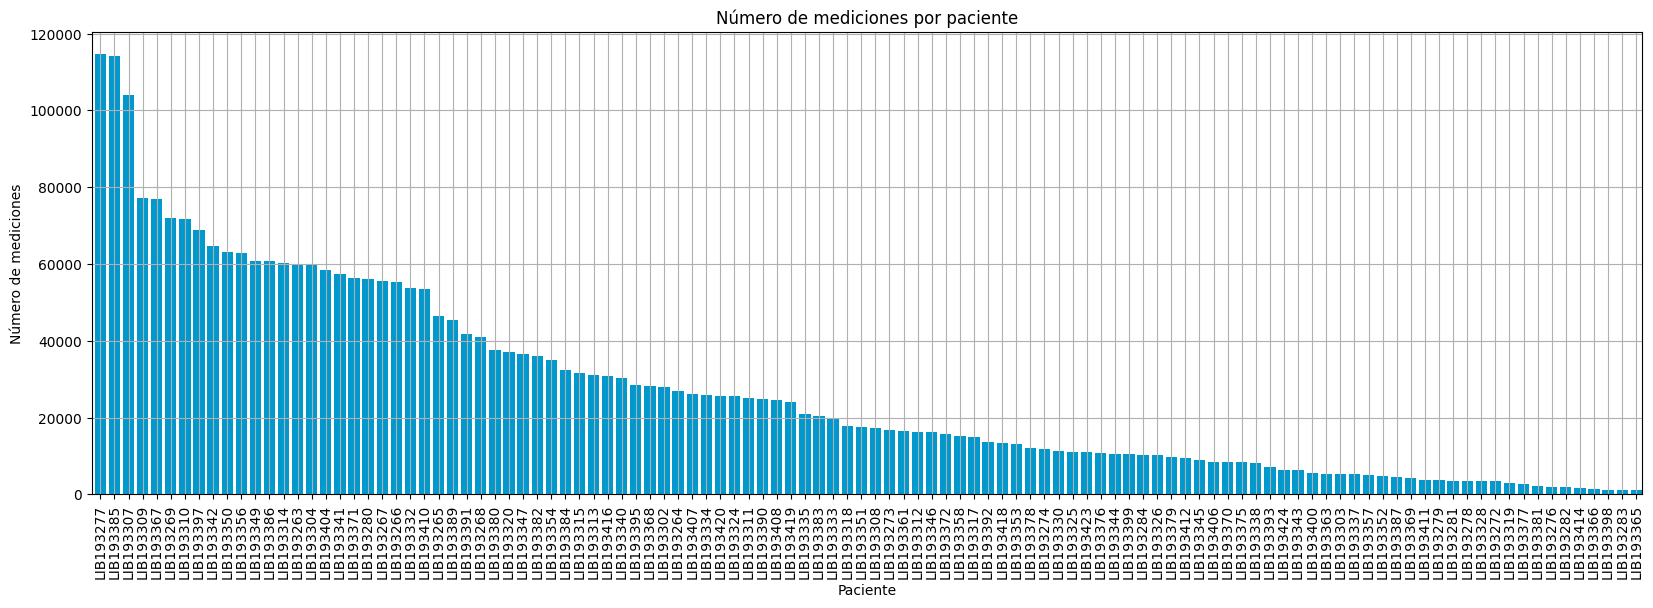

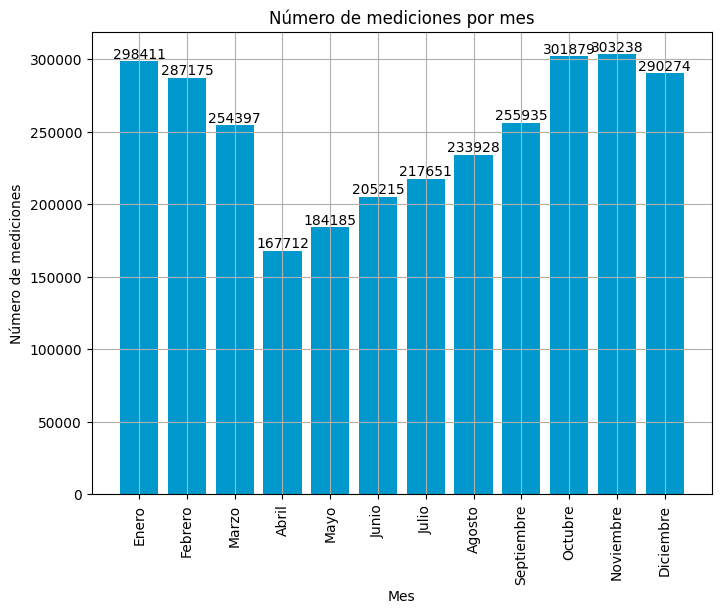

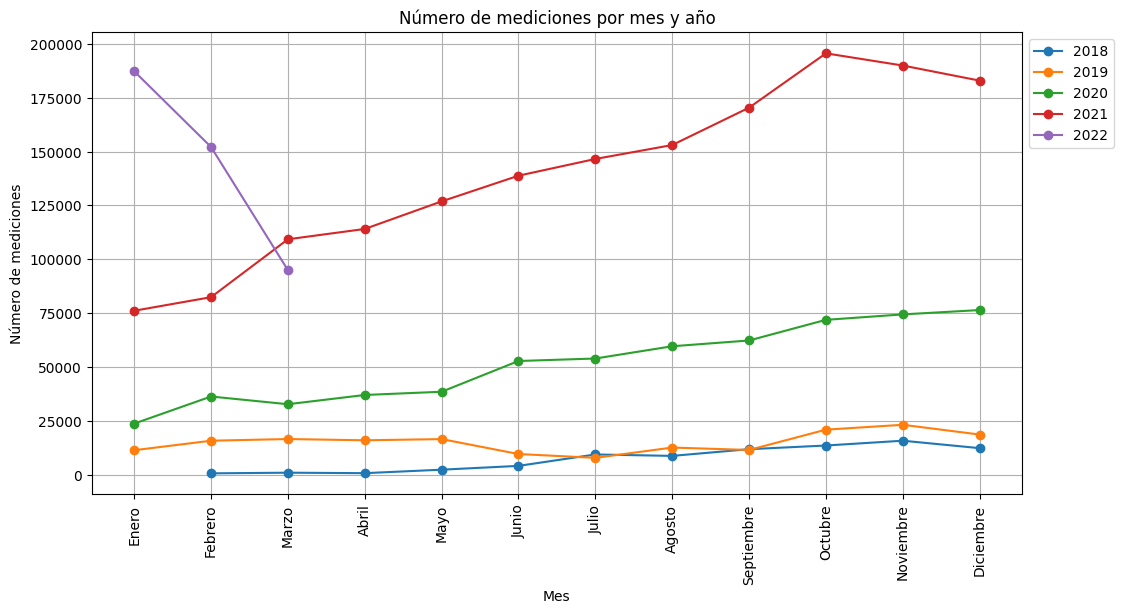

C:\Users\XCoret\AppData\Local\Temp\ipykernel_18276\3441895873.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['Measurement_time'] = pd.to_datetime(dataframe['Measurement_time'])


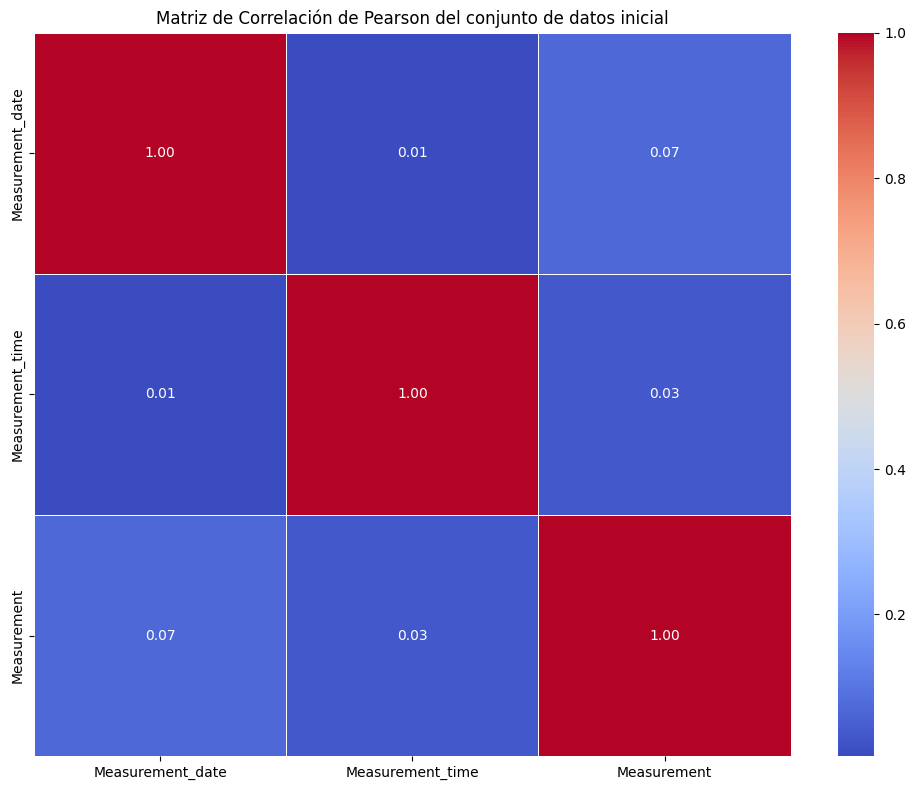

Añadiendo variables inferidas de la medición:
	"Difference", "Trend", "Diagnostic"
Añadiendo variables inferidas de la fecha:
	"Year", "Month", "Day", "Weekday"
Añadiendo variables inferidas de la hora:
	"Hour", "Minute", "Daytime"
Añadiendo fecha y hora en formato Unix:
	"Unix_datetime"
Añadiendo diferencia de tiempo entre registros anteriores por paciente:
	"Time_diff"


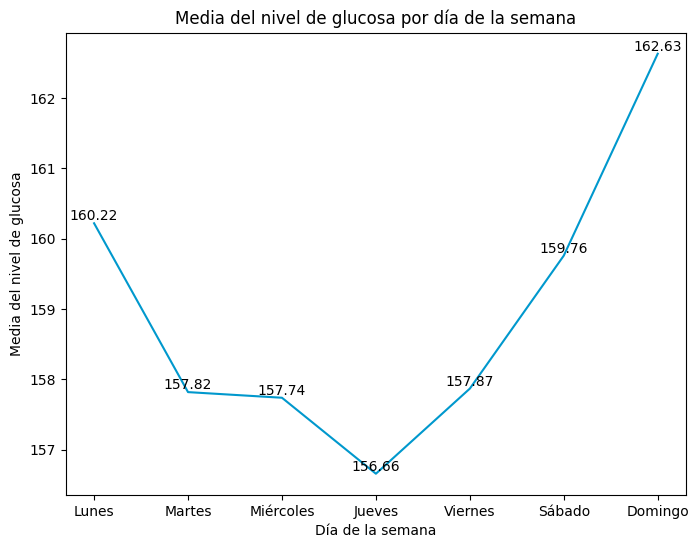

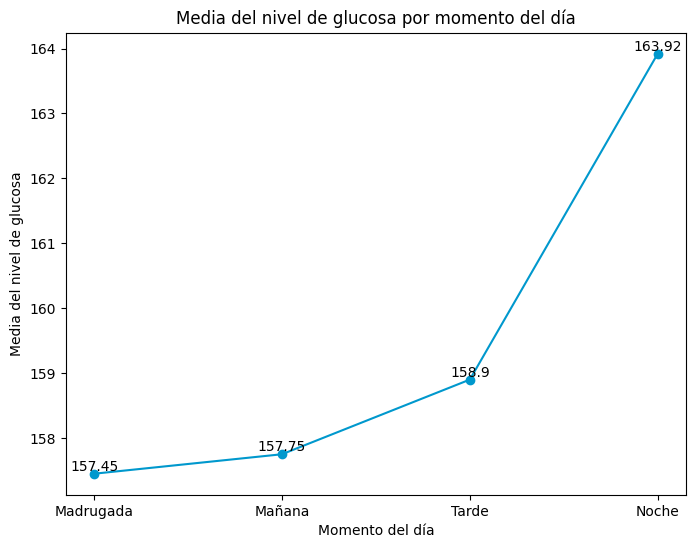

C:\Users\XCoret\AppData\Local\Temp\ipykernel_18276\3441895873.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['Measurement_time'] = pd.to_datetime(dataframe['Measurement_time'])


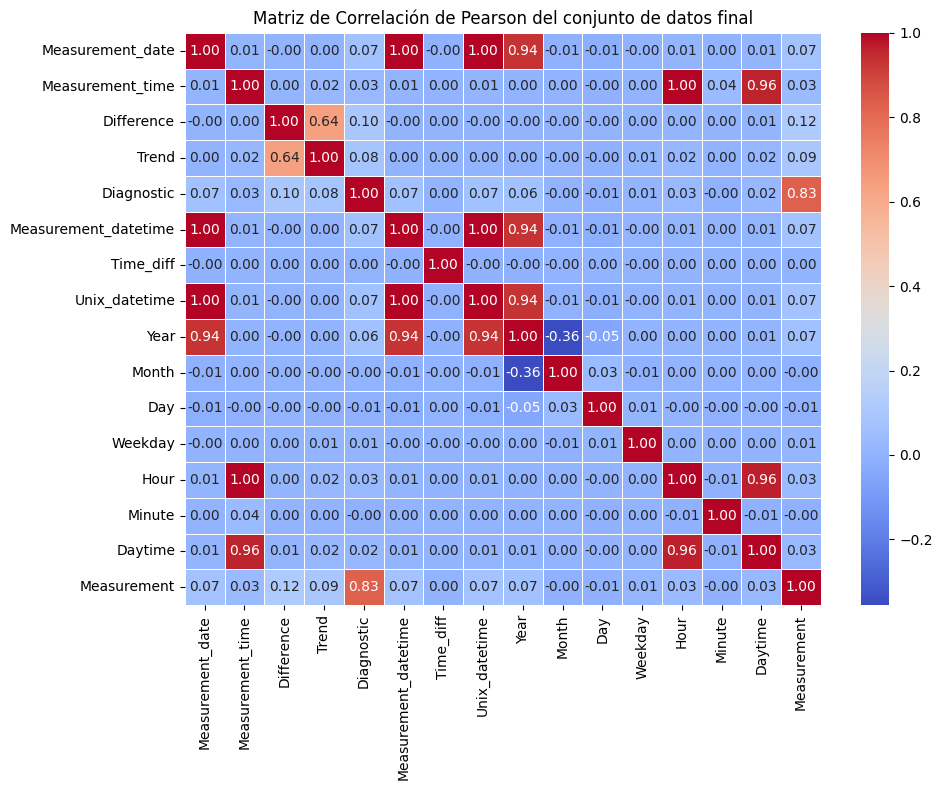

Creando series temporales





===== Caso1 =====
Variables usadas: ['Measurement']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 1)
Shape of labels after split:  (210696,)
[[0.1282608695652174], [0.11304347826086958], [0.1], [0.09782608695652176], [0.09782608695652176], [0.10217391304347825], [0.10434782608695653], [0.11521739130434783], [0.14347826086956522], [0.2043478260869565], [0.2717391304347826], [0.31956521739130433]]
0.31956521739130433
Secuencias totales: 210696 (2528352 registros)
(168556, 12, 1)
(168556,)
Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.14565217 0.15217391 0.15652174 0.19565217 0.2326087  0.23478261
 0.21521739 0.21086957 0.21304348 0.18913043 0.17826087 0.19782609]
Etiqueta: 0.19782608695652176

Secuencias de validación: 21070 (10%) - Etiquetas de validación: 21070
Primera secuencia: 
[0.11304348 0.10434783 0.09782609 0.1173913  0.14782609 0.14130435


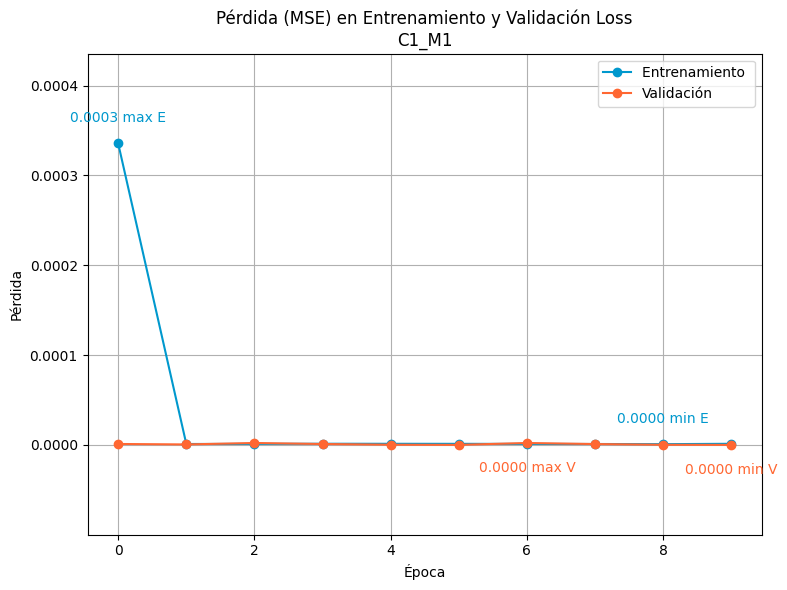


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 3.6390e-09
Pérdida (MSE) : 3.63898000621532e-09
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.0007700108945995175
Error Absoluto Medio (MAE): 0.017188020515169856
Puntuación R^2: 0.99999981513995


<Figure size 640x480 with 0 Axes>

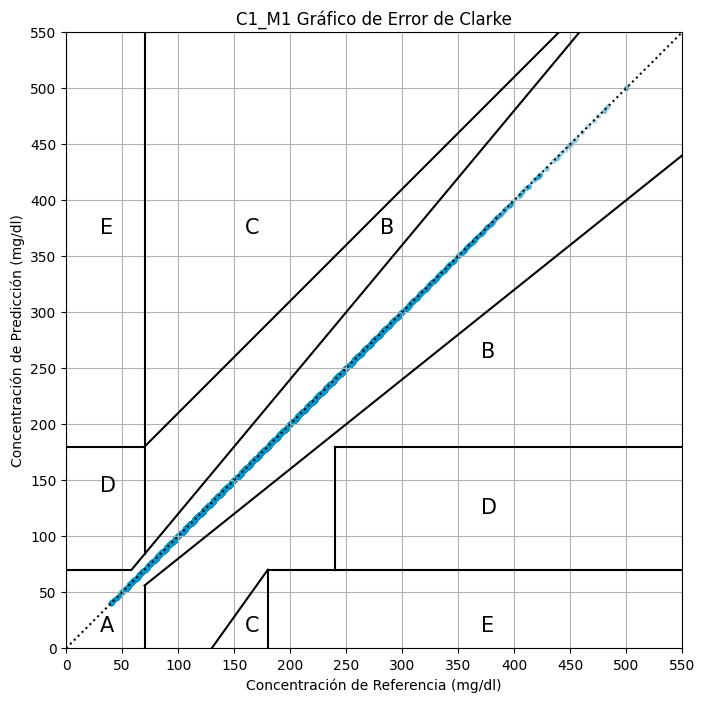

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C1_M2) ====
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 12, 256)           265216    
                                                                 
 dropout (Dropout)           (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 128)               197632    
                                                    

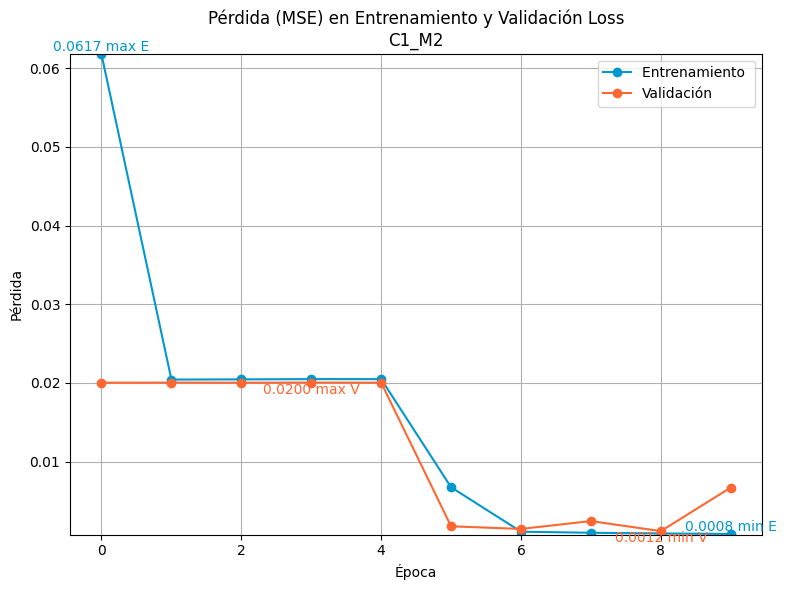


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 3s 4ms/step - loss: 0.0067
Pérdida (MSE) : 0.0067025357857346535
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 1418.2566758283117
Error Absoluto Medio (MAE): 37.52350094396467
Puntuación R^2: 0.6595126096549002


<Figure size 640x480 with 0 Axes>

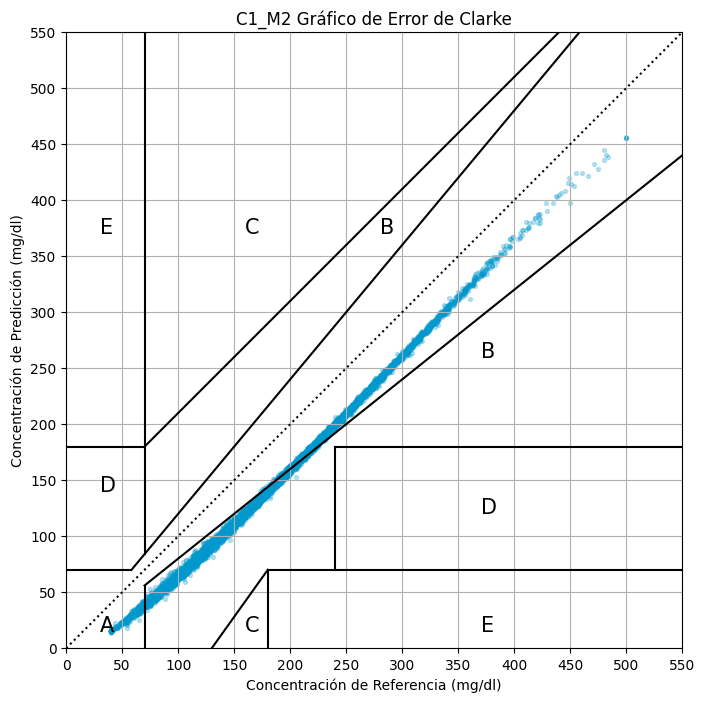

Región A: 6070 puntos dentro del 20% del sensor de referencia
Región B: 15000 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 128)               67072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 batch_normaliza

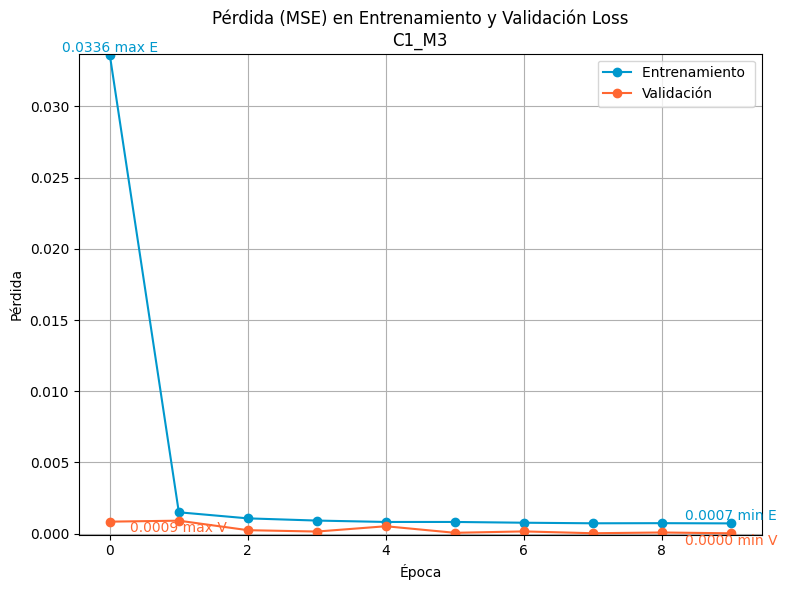


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 2.1123e-05
Pérdida (MSE) : 2.1122612452018075e-05
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 4.469546916099761
Error Absoluto Medio (MAE): 1.572406330298742
Puntuación R^2: 0.9989269753554313


<Figure size 640x480 with 0 Axes>

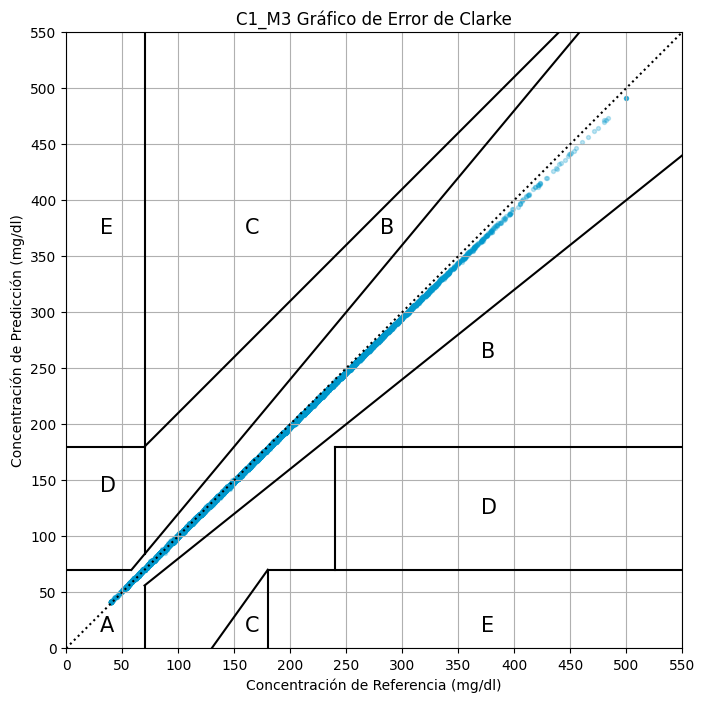

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070





===== Caso2 =====
Variables usadas: ['Month', 'Day']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 3)
Shape of labels after split:  (210696,)
[[0.4545454545454545, 0.26666666666666666, 0.1282608695652174], [0.4545454545454545, 0.26666666666666666, 0.11304347826086958], [0.4545454545454545, 0.26666666666666666, 0.1], [0.4545454545454545, 0.26666666666666666, 0.09782608695652176], [0.4545454545454545, 0.26666666666666666, 0.09782608695652176], [0.4545454545454545, 0.26666666666666666, 0.10217391304347825], 

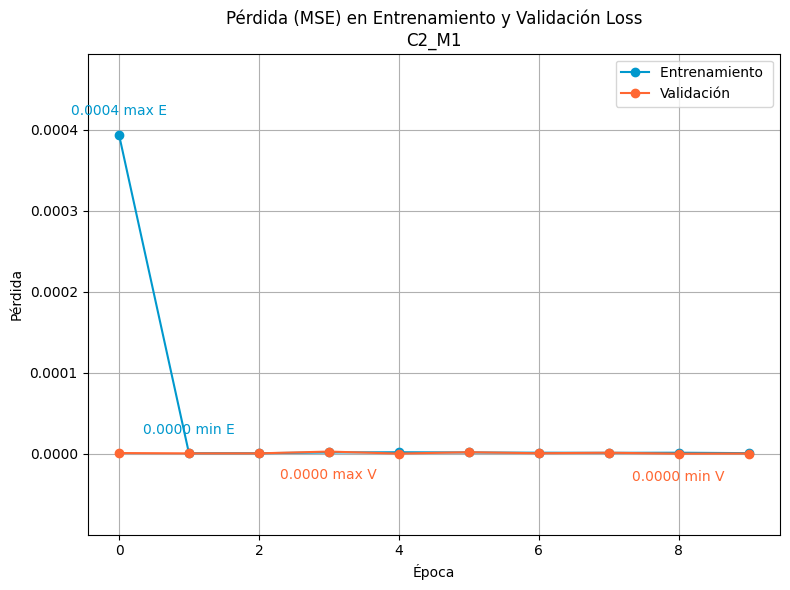


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 2.4912e-07
Pérdida (MSE) : 2.4912236540330923e-07
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.05271438406875558
Error Absoluto Medio (MAE): 0.21884017006503556
Puntuación R^2: 0.9999873446158435


<Figure size 640x480 with 0 Axes>

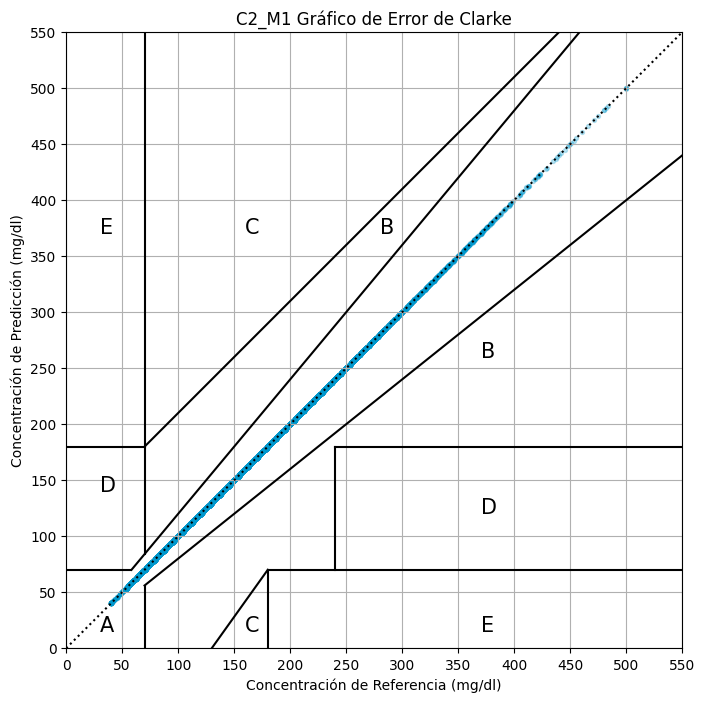

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C2_M2) ====
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 12, 256)           267264    
                                                                 
 dropout_8 (Dropout)         (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_6 (CuDNNLSTM)    (None, 128)               197632    
                                                    

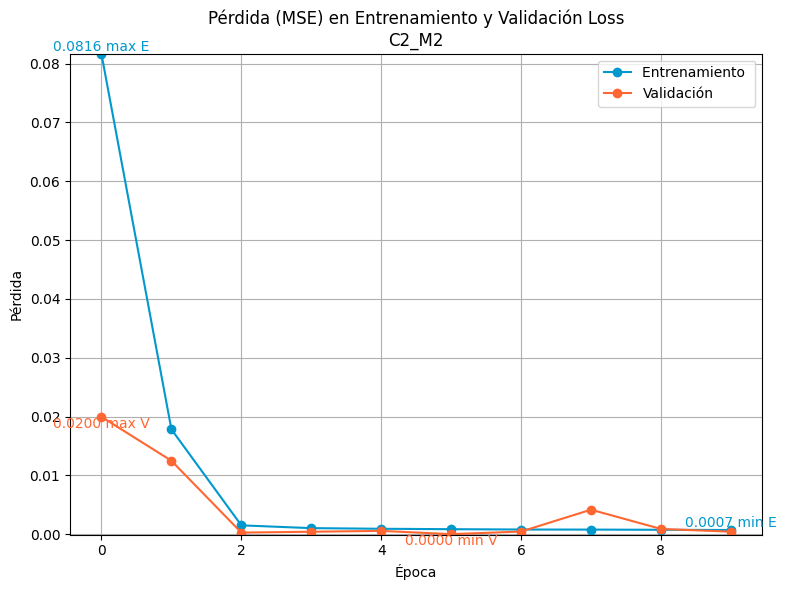


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 4.4691e-04
Pérdida (MSE) : 0.00044690657523460686
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 94.56545176165294
Error Absoluto Medio (MAE): 9.64134762858575
Puntuación R^2: 0.977297237914762


<Figure size 640x480 with 0 Axes>

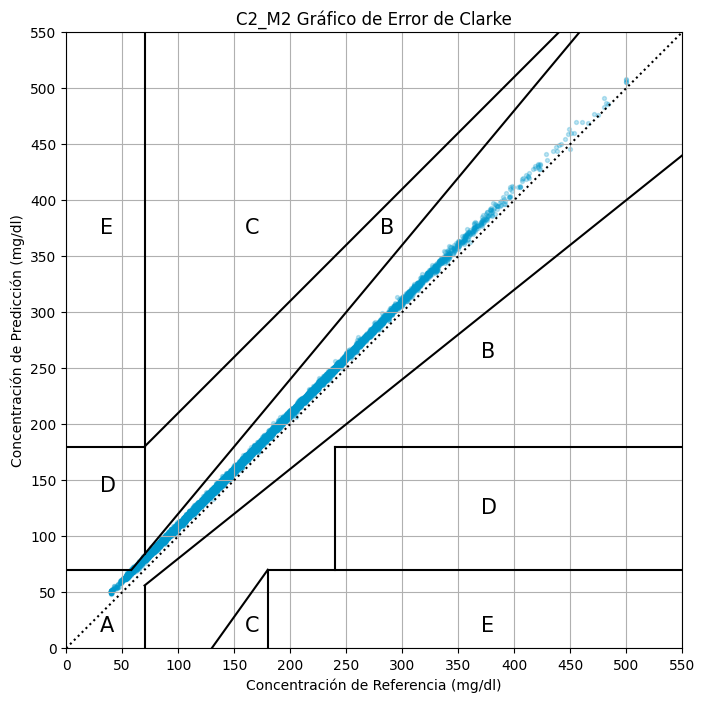

Región A: 21062 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 8 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_7 (CuDNNLSTM)    (None, 128)               68096     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalizatio

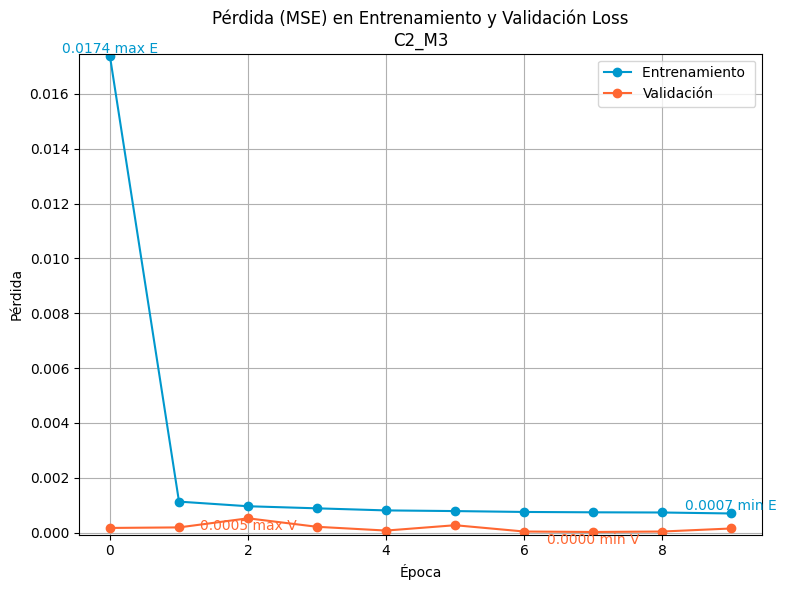


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 1.4573e-04
Pérdida (MSE) : 0.00014573353109881282
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 30.837194127453433
Error Absoluto Medio (MAE): 4.281561321843334
Puntuación R^2: 0.9925967732548203


<Figure size 640x480 with 0 Axes>

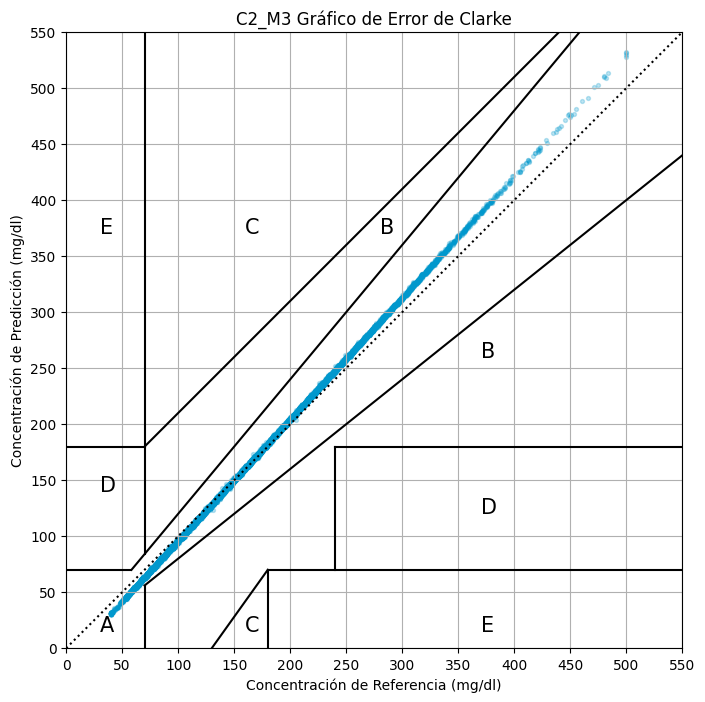

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070





===== Caso3 =====
Variables usadas: ['Weekday']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 2)
Shape of labels after split:  (210696,)
[[0.16666666666666666, 0.1282608695652174], [0.16666666666666666, 0.11304347826086958], [0.16666666666666666, 0.1], [0.16666666666666666, 0.09782608695652176], [0.16666666666666666, 0.09782608695652176], [0.16666666666666666, 0.10217391304347825], [0.16666666666666666, 0.10434782608695653], [0.16666666666666666, 0.11521739130434783], [0.16666666666666666, 0.1434782608695

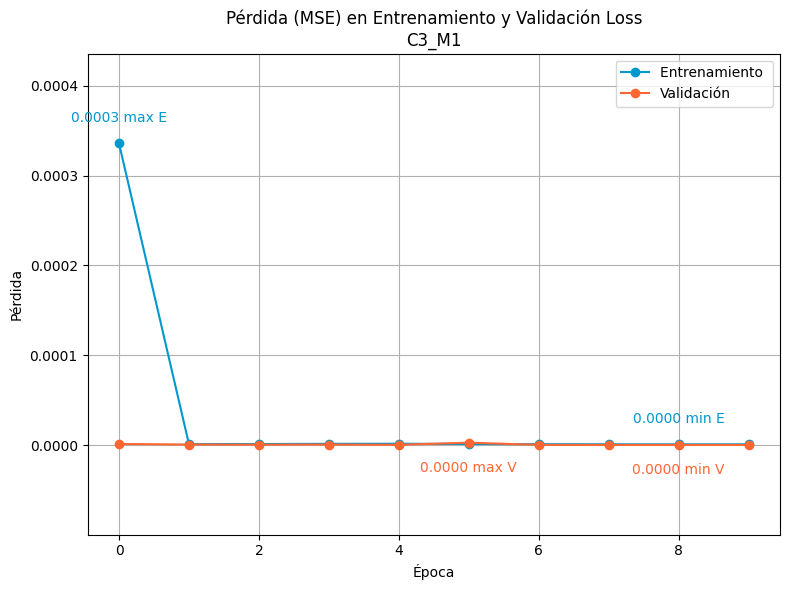


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 1.0253e-07
Pérdida (MSE) : 1.0253041438090804e-07
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.021695361059071272
Error Absoluto Medio (MAE): 0.12259301890340304
Puntuación R^2: 0.999994791495083


<Figure size 640x480 with 0 Axes>

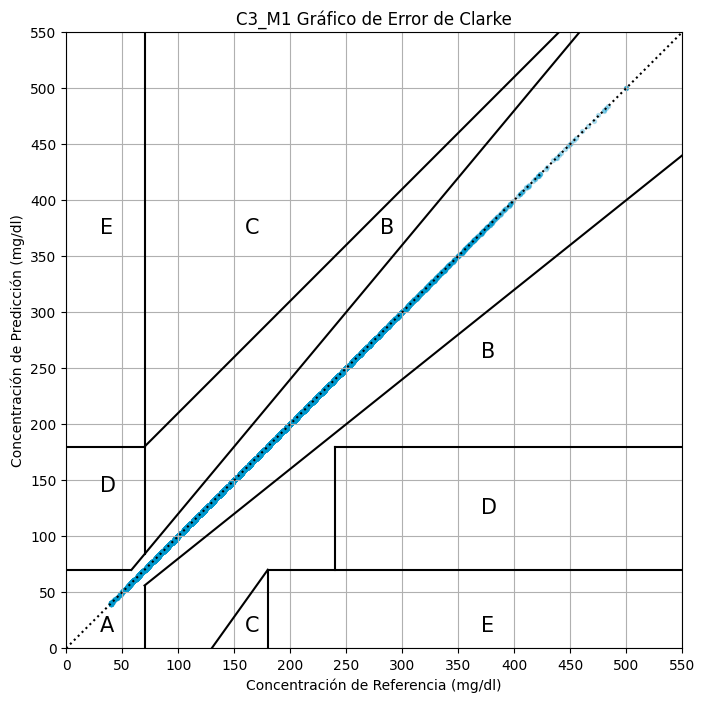

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C3_M2) ====
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_9 (CuDNNLSTM)    (None, 12, 256)           266240    
                                                                 
 dropout_16 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_10 (CuDNNLSTM)   (None, 128)               197632    
                                                    

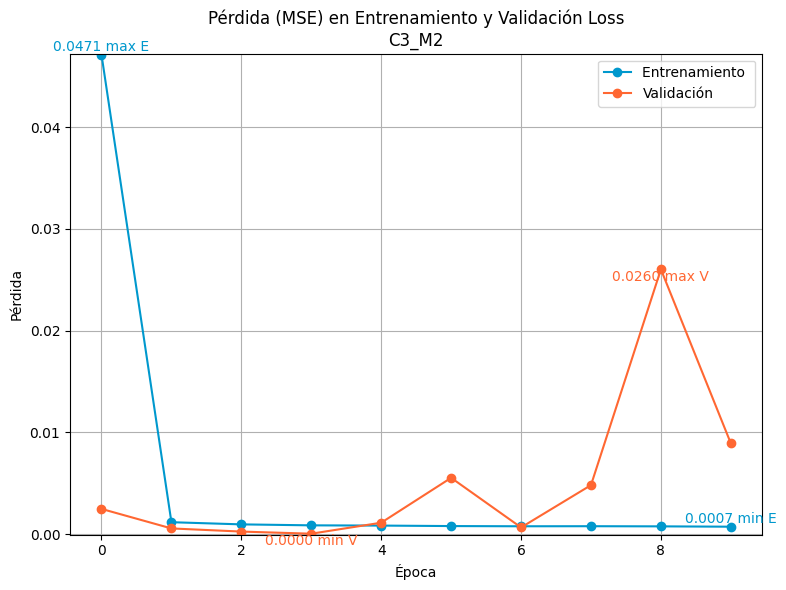


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 0.0089
Pérdida (MSE) : 0.008920155465602875
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 1887.50527836015
Error Absoluto Medio (MAE): 43.4086836997287
Puntuación R^2: 0.5468579436679853


<Figure size 640x480 with 0 Axes>

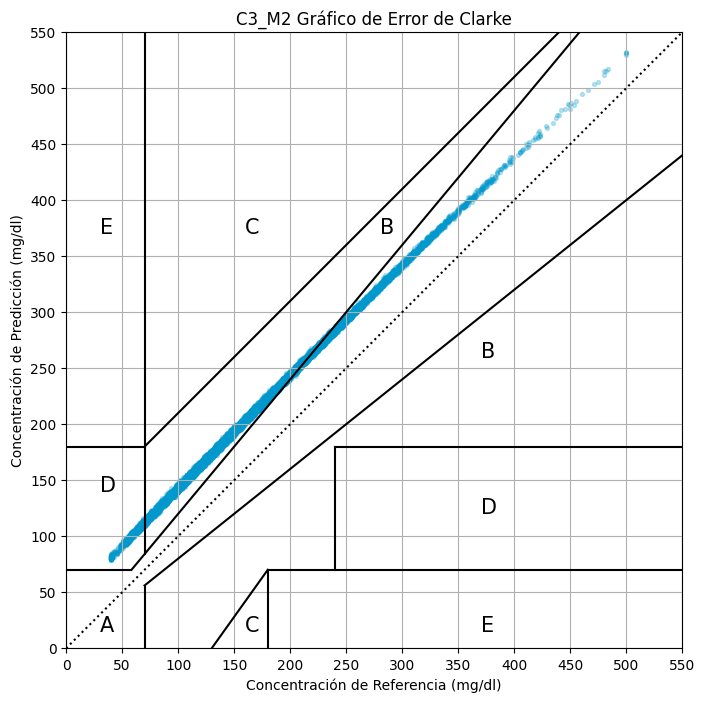

Región A: 3584 puntos dentro del 20% del sensor de referencia
Región B: 16518 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 968 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_11 (CuDNNLSTM)   (None, 128)               67584     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               33024     
                                                                 
 batch_normali

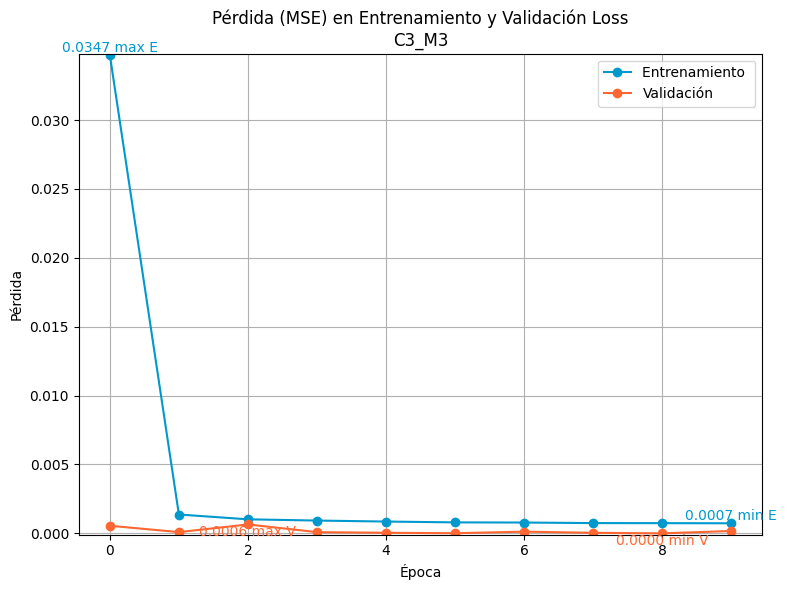


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 1.6941e-04
Pérdida (MSE) : 0.0001694088423391804
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 35.84693368337491
Error Absoluto Medio (MAE): 4.665994631491625
Puntuación R^2: 0.9913940620835804


<Figure size 640x480 with 0 Axes>

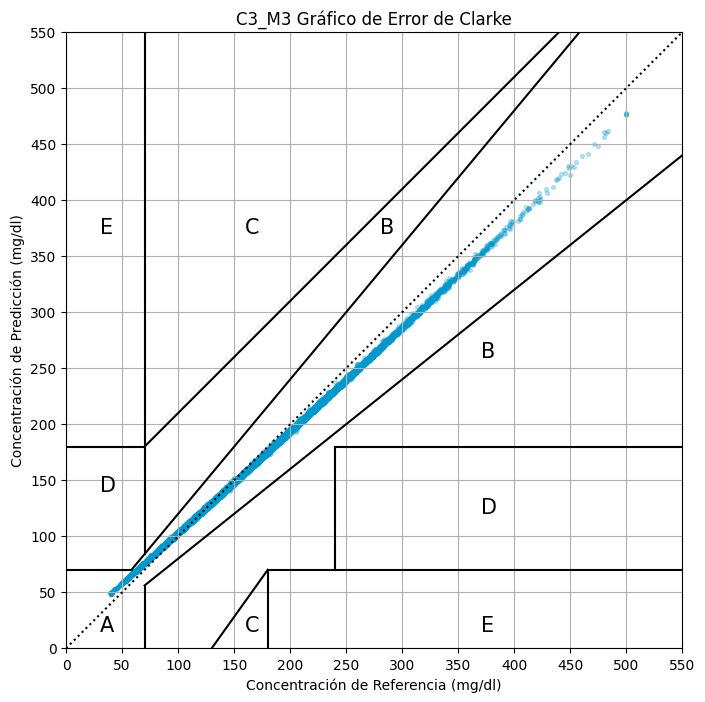

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070





===== Caso4 =====
Variables usadas: ['Hour', 'Minute']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 3)
Shape of labels after split:  (210696,)
[[0.8260869565217391, 0.13559322033898305, 0.1282608695652174], [0.8260869565217391, 0.3898305084745763, 0.11304347826086958], [0.8260869565217391, 0.6440677966101694, 0.1], [0.8260869565217391, 0.8983050847457628, 0.09782608695652176], [0.8695652173913043, 0.13559322033898305, 0.09782608695652176], [0.8695652173913043, 0.3898305084745763, 0.10217391304347825], [0

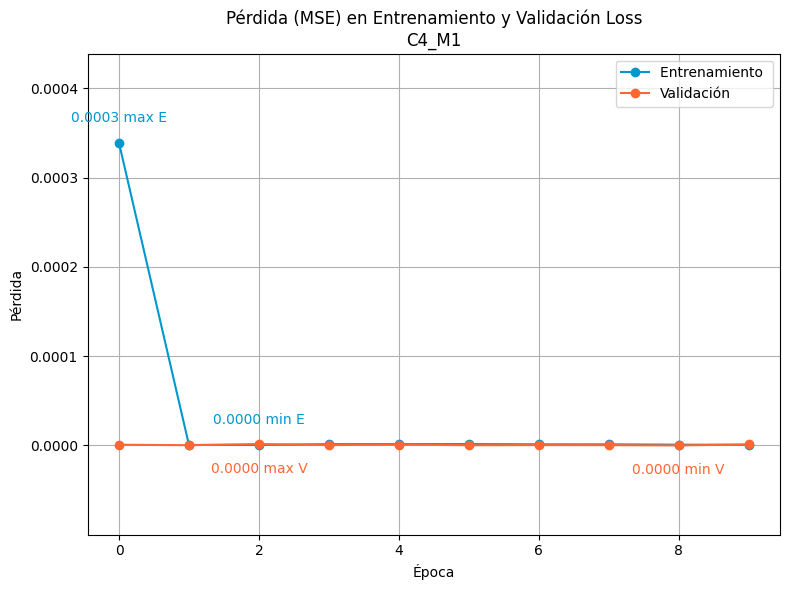


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 1.1728e-06
Pérdida (MSE) : 1.1728091067197965e-06
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.24816636113695376
Error Absoluto Medio (MAE): 0.4898600805976932
Puntuación R^2: 0.9999404215625316


<Figure size 640x480 with 0 Axes>

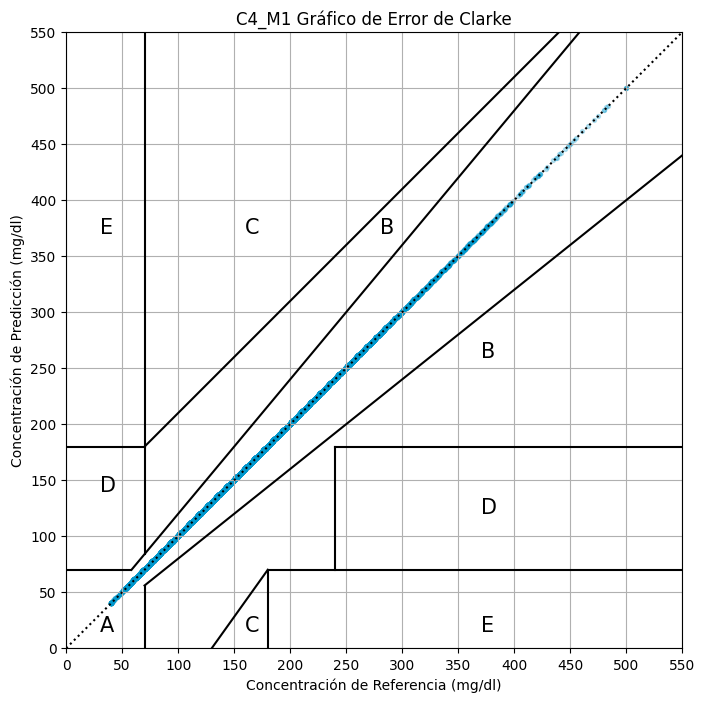

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C4_M2) ====
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_13 (CuDNNLSTM)   (None, 12, 256)           267264    
                                                                 
 dropout_24 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_14 (CuDNNLSTM)   (None, 128)               197632    
                                                   

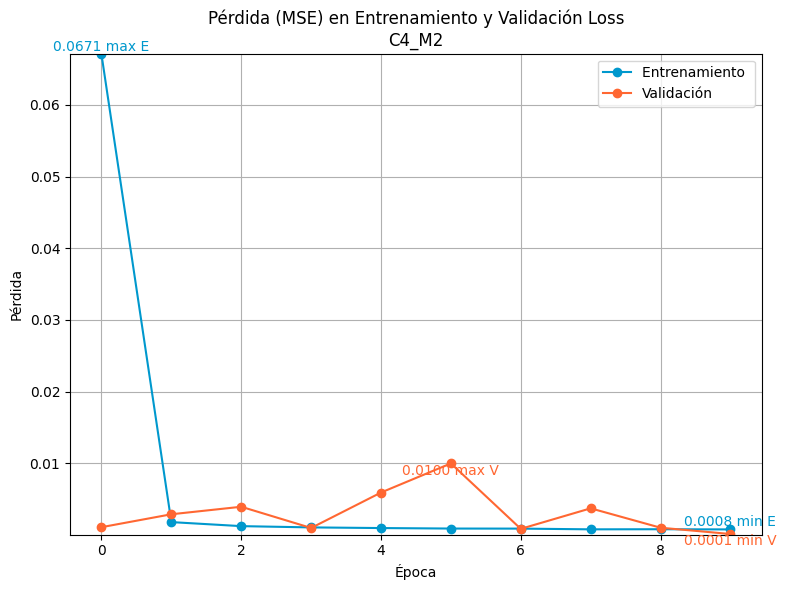


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 3s 4ms/step - loss: 1.1554e-04
Pérdida (MSE) : 0.00011553566582733765
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 24.447329620293996
Error Absoluto Medio (MAE): 3.855941488667016
Puntuación R^2: 0.994130817358248


<Figure size 640x480 with 0 Axes>

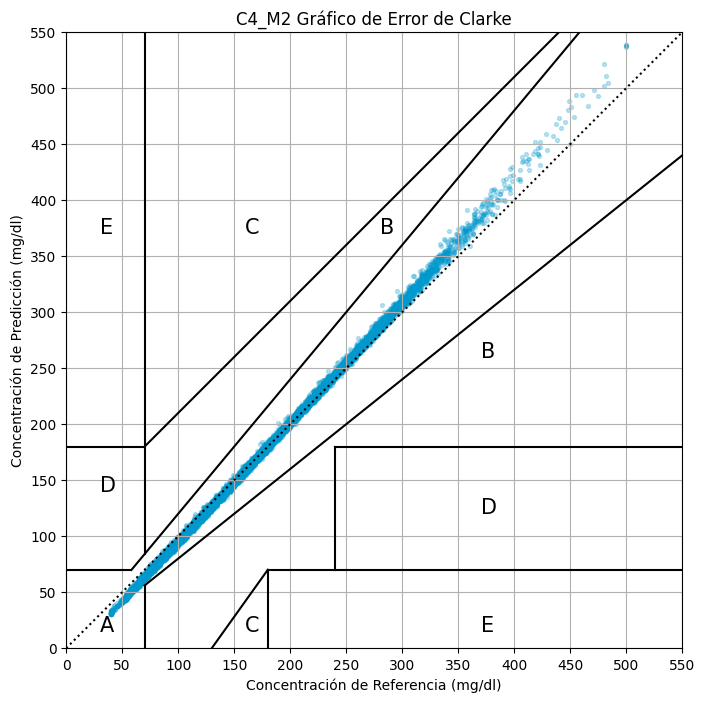

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_15 (CuDNNLSTM)   (None, 128)               68096     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalizati

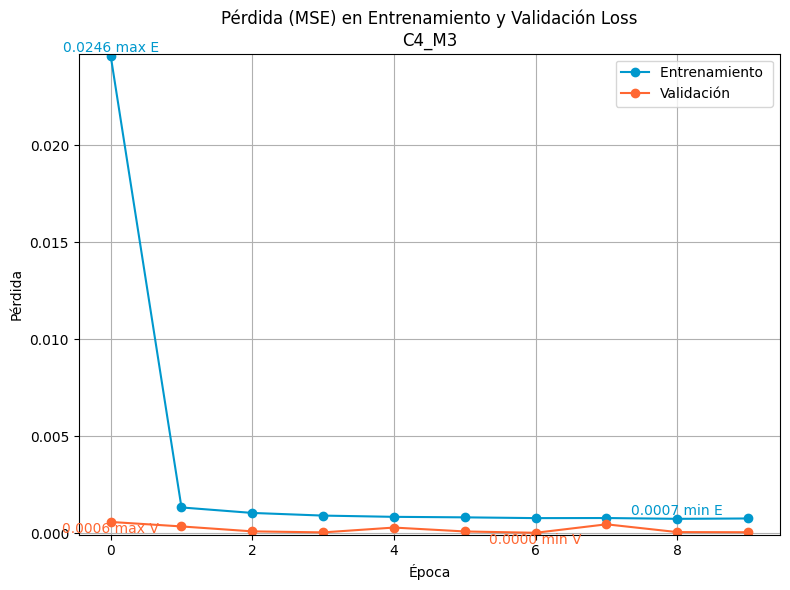


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 3.9592e-05
Pérdida (MSE) : 3.959172317991033e-05
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 8.377611432675598
Error Absoluto Medio (MAE): 2.71628567569336
Puntuación R^2: 0.9979887483678714


<Figure size 640x480 with 0 Axes>

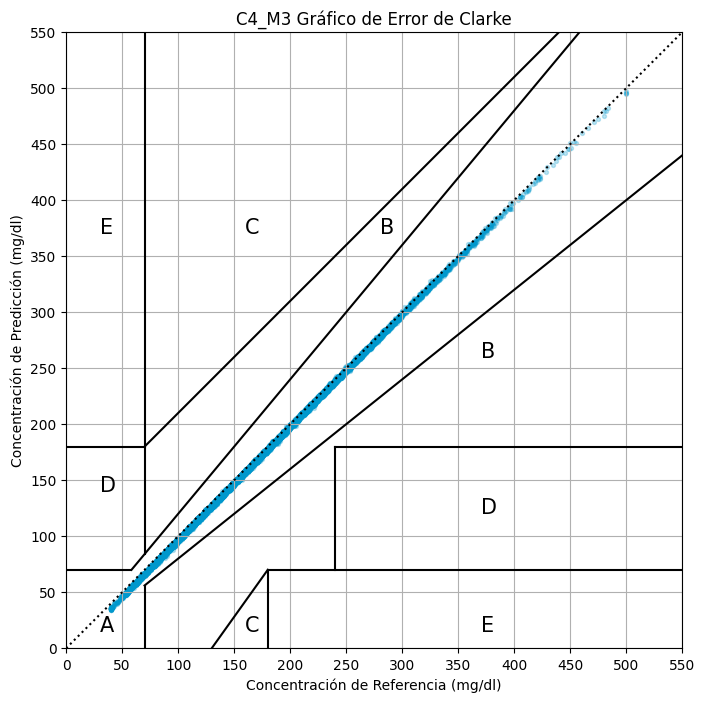

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070





===== Caso5 =====
Variables usadas: ['Daytime']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 2)
Shape of labels after split:  (210696,)
[[0.6666666666666666, 0.1282608695652174], [0.6666666666666666, 0.11304347826086958], [0.6666666666666666, 0.1], [0.6666666666666666, 0.09782608695652176], [1.0, 0.09782608695652176], [1.0, 0.10217391304347825], [1.0, 0.10434782608695653], [1.0, 0.11521739130434783], [1.0, 0.14347826086956522], [1.0, 0.2043478260869565], [1.0, 0.2717391304347826], [1.0, 0.319565217391304

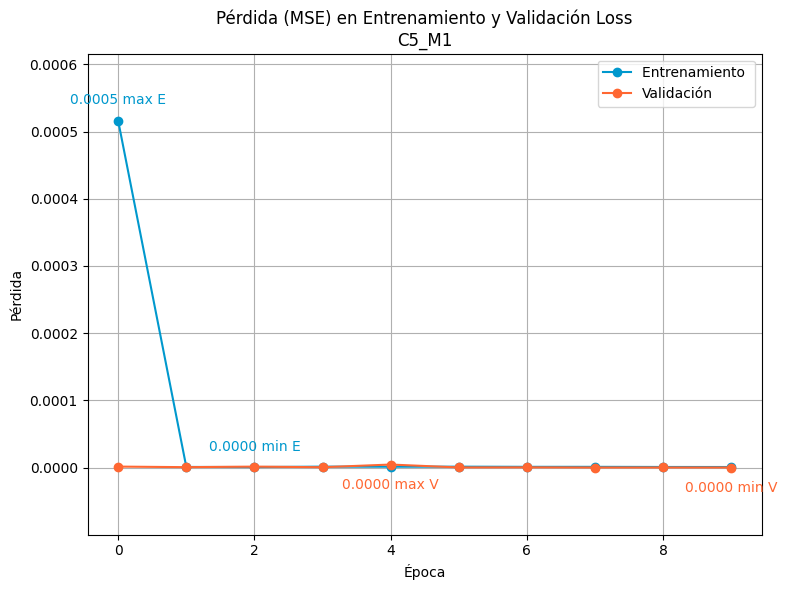


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 1.5759e-08
Pérdida (MSE) : 1.575942931708596e-08
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.003334683257104737
Error Absoluto Medio (MAE): 0.03854978929835531
Puntuación R^2: 0.9999991994272833


<Figure size 640x480 with 0 Axes>

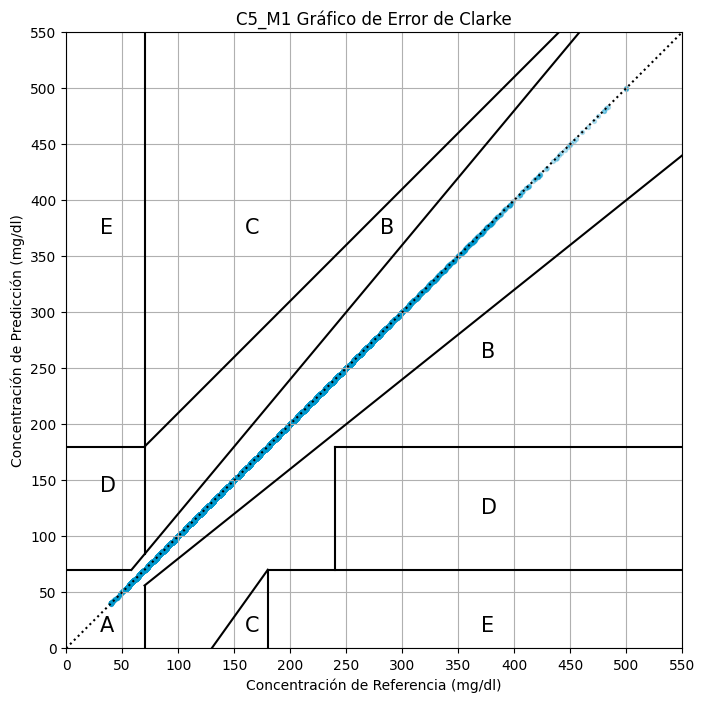

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C5_M2) ====
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_17 (CuDNNLSTM)   (None, 12, 256)           266240    
                                                                 
 dropout_32 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_18 (CuDNNLSTM)   (None, 128)               197632    
                                                   

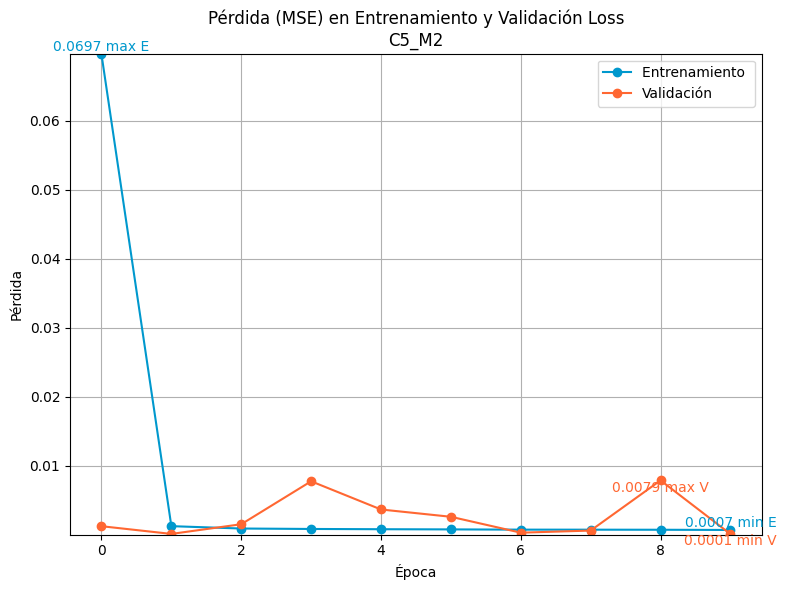


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 3s 4ms/step - loss: 1.1376e-04
Pérdida (MSE) : 0.00011375606845831499
659/659 [==============================] - 2s 3ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 24.07078744554091
Error Absoluto Medio (MAE): 4.424587561702863
Puntuación R^2: 0.9942212155665707


<Figure size 640x480 with 0 Axes>

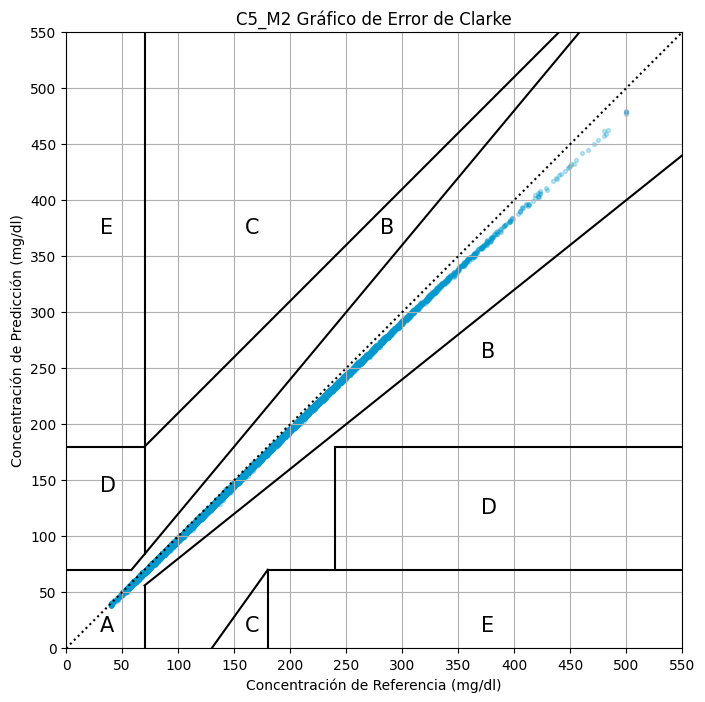

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_19 (CuDNNLSTM)   (None, 128)               67584     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalizati

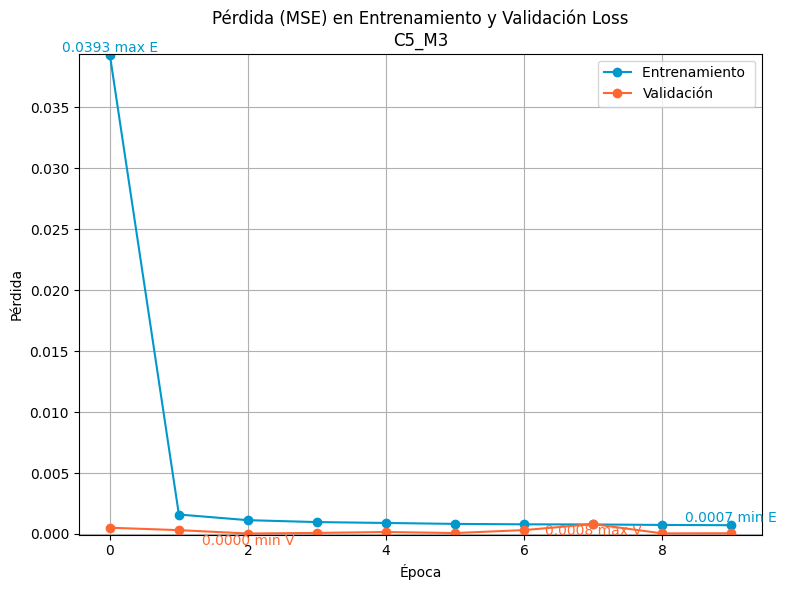


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 5.6087e-05
Pérdida (MSE) : 5.608669380308129e-05
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 11.86793495140411
Error Absoluto Medio (MAE): 2.9515239719197166
Puntuación R^2: 0.997150810379208


<Figure size 640x480 with 0 Axes>

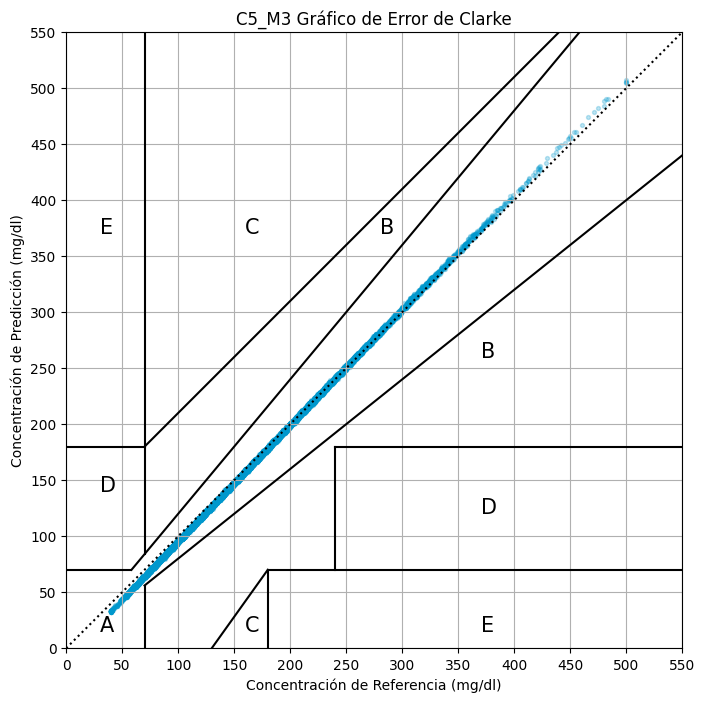

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070





===== Caso6 =====
Variables usadas: ['Trend', 'Diagnostic']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 3)
Shape of labels after split:  (210696,)
[[0.5, 0.5, 0.1282608695652174], [0.0, 0.5, 0.11304347826086958], [0.0, 0.5, 0.1], [0.0, 0.5, 0.09782608695652176], [0.5, 0.5, 0.09782608695652176], [1.0, 0.5, 0.10217391304347825], [1.0, 0.5, 0.10434782608695653], [1.0, 0.5, 0.11521739130434783], [1.0, 0.5, 0.14347826086956522], [1.0, 0.5, 0.2043478260869565], [1.0, 0.5, 0.2717391304347826], [1.0, 1.0, 0.319

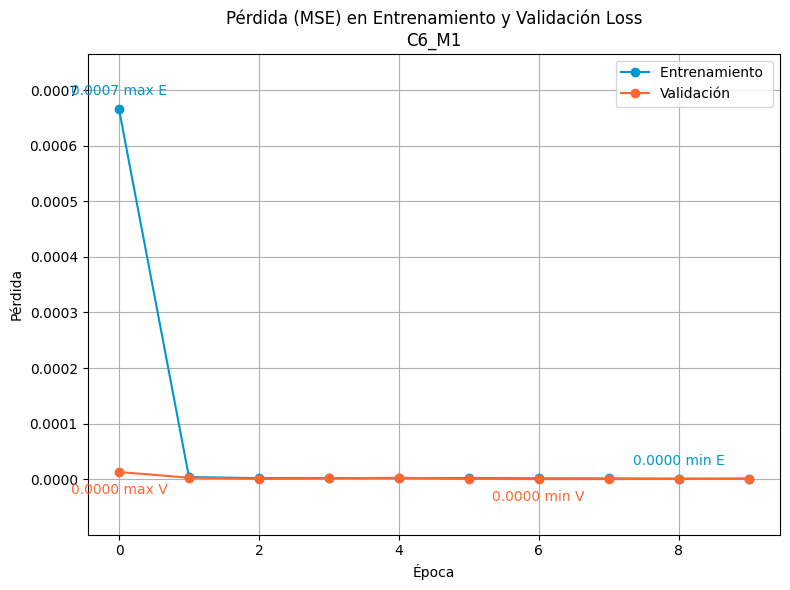


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 5.7491e-07
Pérdida (MSE) : 5.749136562371859e-07
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.12165167771787976
Error Absoluto Medio (MAE): 0.27444115644617134
Puntuación R^2: 0.9999707945233164


<Figure size 640x480 with 0 Axes>

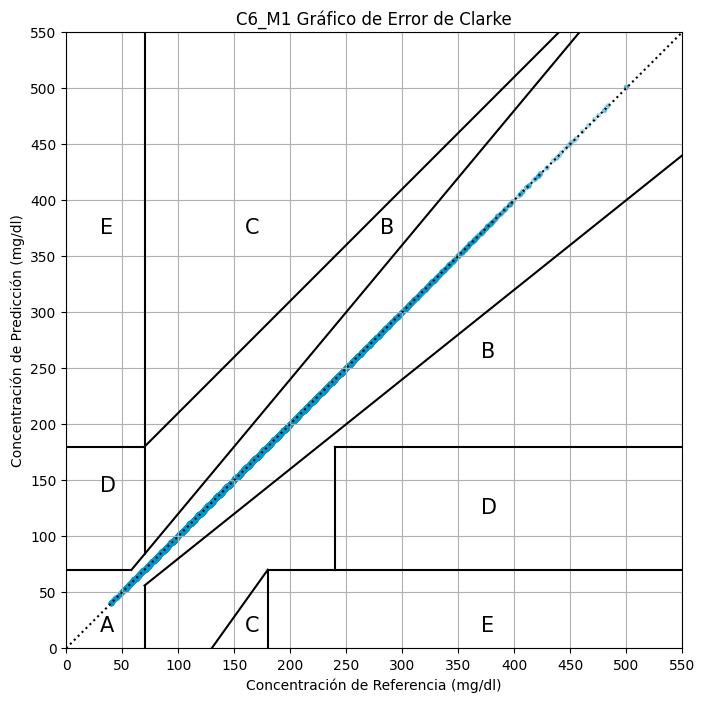

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C6_M2) ====
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_21 (CuDNNLSTM)   (None, 12, 256)           267264    
                                                                 
 dropout_40 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_22 (CuDNNLSTM)   (None, 128)               197632    
                                                   

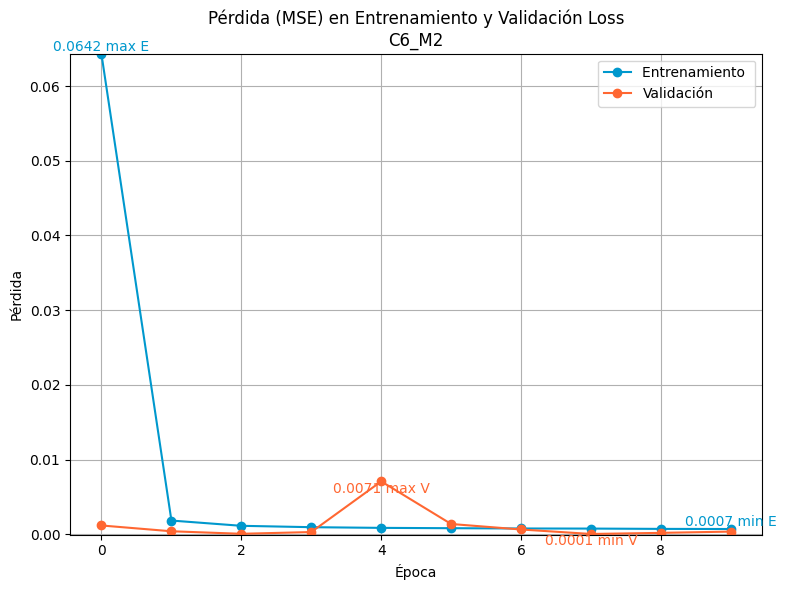


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 3s 4ms/step - loss: 3.8912e-04
Pérdida (MSE) : 0.0003891168744303286
659/659 [==============================] - 2s 3ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 82.33714232045558
Error Absoluto Medio (MAE): 8.701578023753916
Puntuación R^2: 0.9802329442935344


<Figure size 640x480 with 0 Axes>

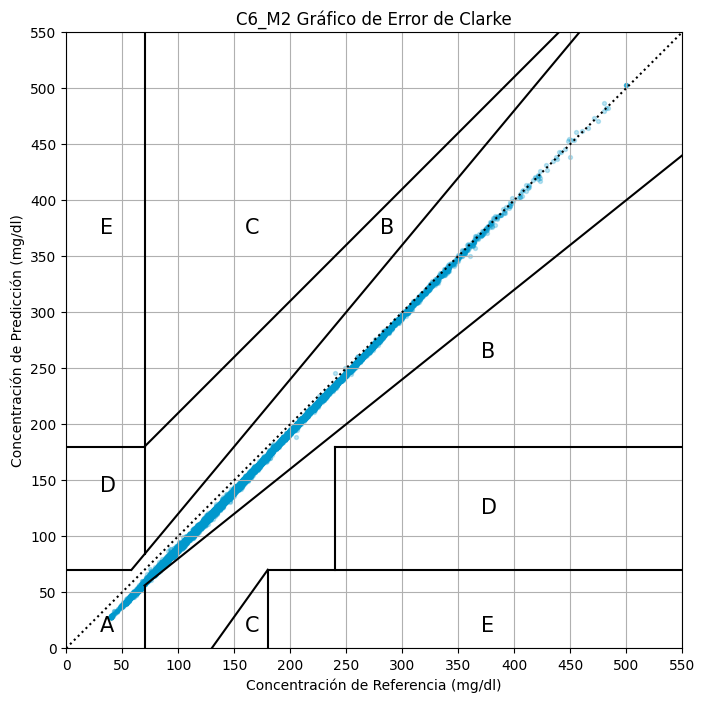

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_23 (CuDNNLSTM)   (None, 128)               68096     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalizati

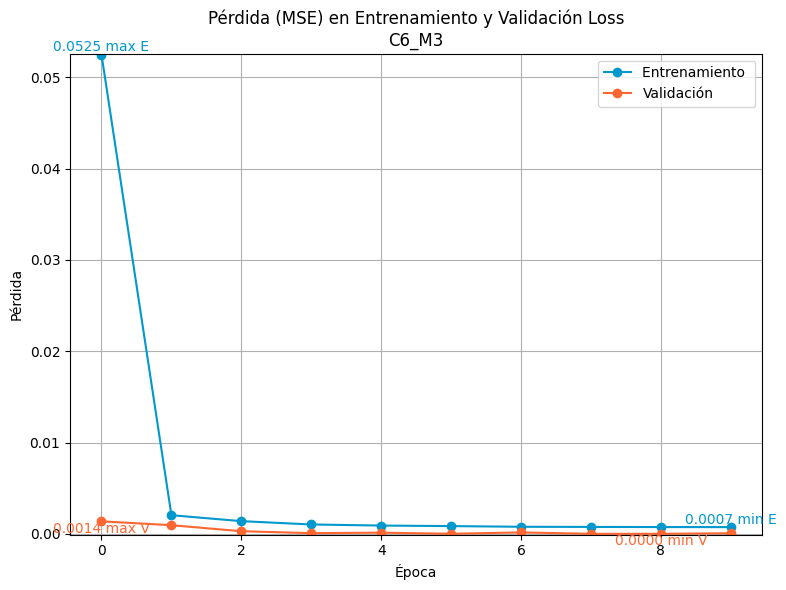


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 7.3844e-05
Pérdida (MSE) : 7.384423952316865e-05
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 15.625436552513284
Error Absoluto Medio (MAE): 3.793651500424901
Puntuación R^2: 0.9962487297218884


<Figure size 640x480 with 0 Axes>

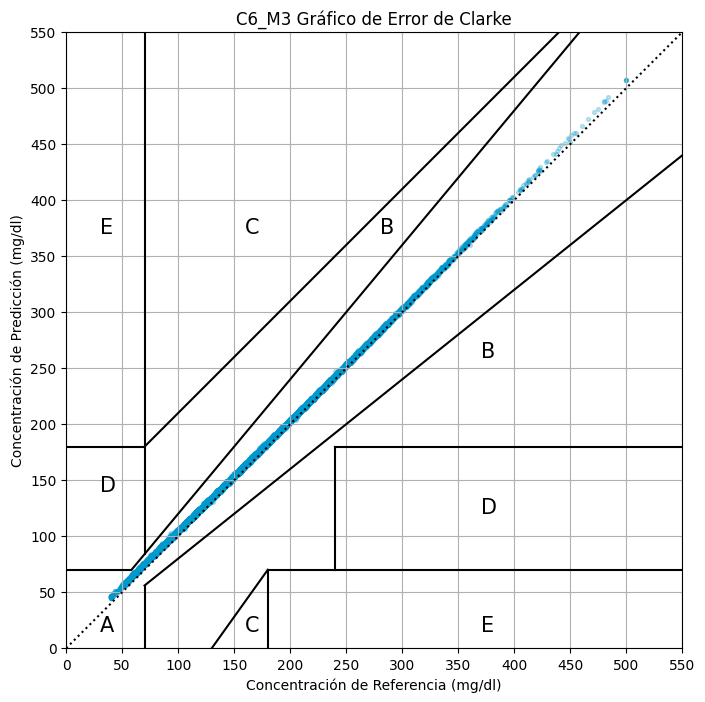

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070





===== Caso7 =====
Variables usadas: ['Difference']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 2)
Shape of labels after split:  (210696,)
[[0.5, 0.1282608695652174], [0.48267326732673266, 0.11304347826086958], [0.48514851485148514, 0.1], [0.4975247524752475, 0.09782608695652176], [0.5, 0.09782608695652176], [0.504950495049505, 0.10217391304347825], [0.5024752475247525, 0.10434782608695653], [0.5123762376237624, 0.11521739130434783], [0.5321782178217822, 0.14347826086956522], [0.5693069306930694, 0.20434

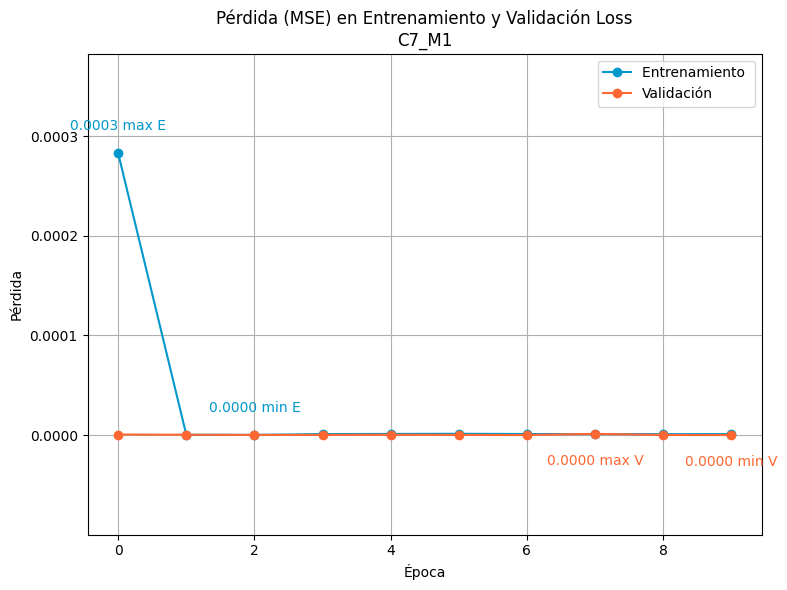


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 7.0105e-09
Pérdida (MSE) : 7.010547253827326e-09
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.0014833956492230733
Error Absoluto Medio (MAE): 0.029157590390835444
Puntuación R^2: 0.9999996438743973


<Figure size 640x480 with 0 Axes>

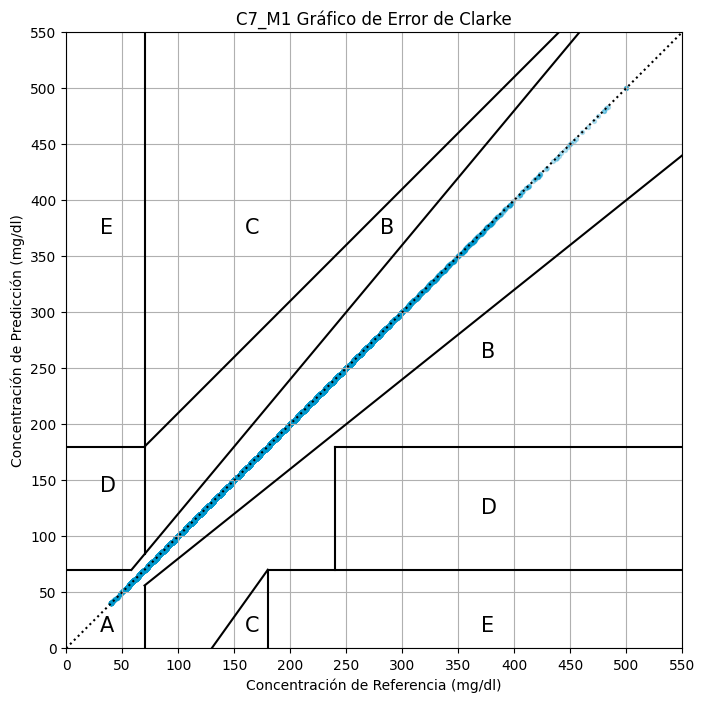

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C7_M2) ====
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_25 (CuDNNLSTM)   (None, 12, 256)           266240    
                                                                 
 dropout_48 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_26 (CuDNNLSTM)   (None, 128)               197632    
                                                   

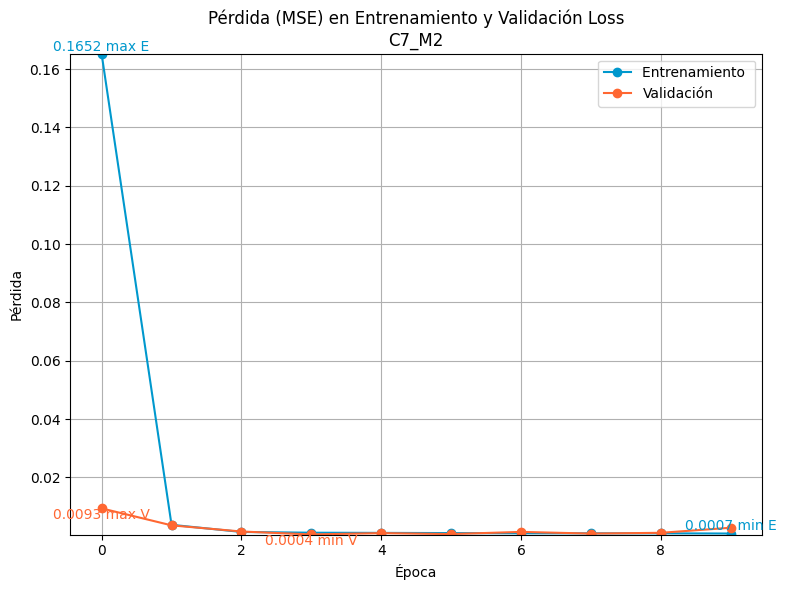


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 0.0027
Pérdida (MSE) : 0.002699732780456543
659/659 [==============================] - 2s 3ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 571.2633679591688
Error Absoluto Medio (MAE): 23.70159920546247
Puntuación R^2: 0.8628541810017778


<Figure size 640x480 with 0 Axes>

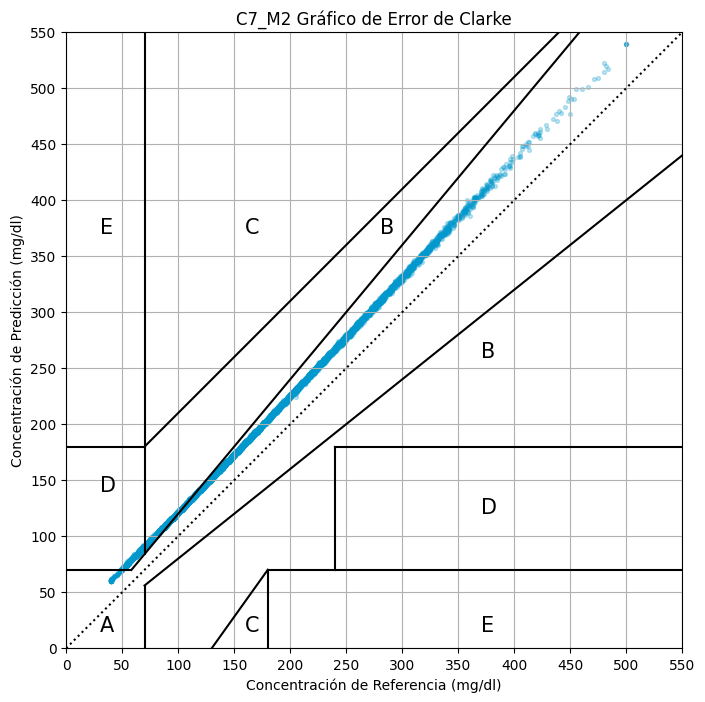

Región A: 16461 puntos dentro del 20% del sensor de referencia
Región B: 3727 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 882 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_27 (CuDNNLSTM)   (None, 128)               67584     
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_65 (Dense)            (None, 256)               33024     
                                                                 
 batch_normal

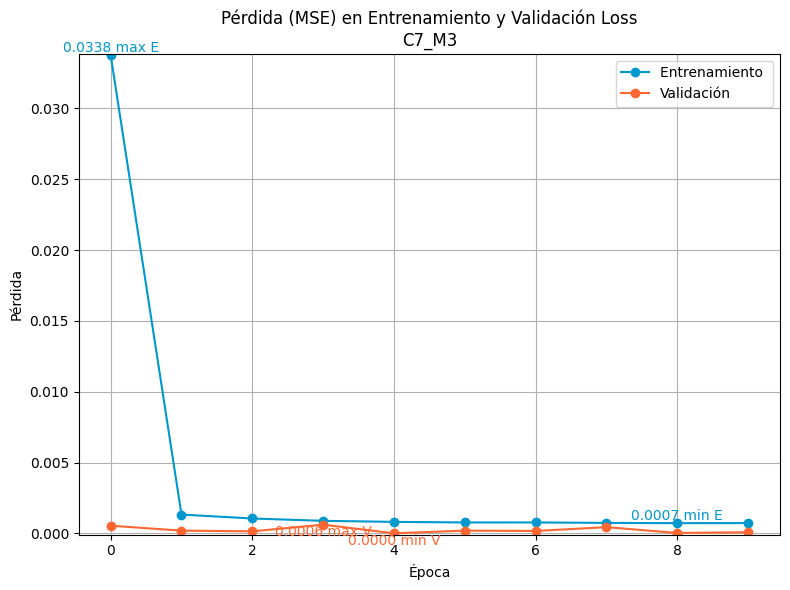


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 8.0969e-05
Pérdida (MSE) : 8.096931560430676e-05
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 17.133097015674867
Error Absoluto Medio (MAE): 3.0056738181311107
Puntuación R^2: 0.9958867787539307


<Figure size 640x480 with 0 Axes>

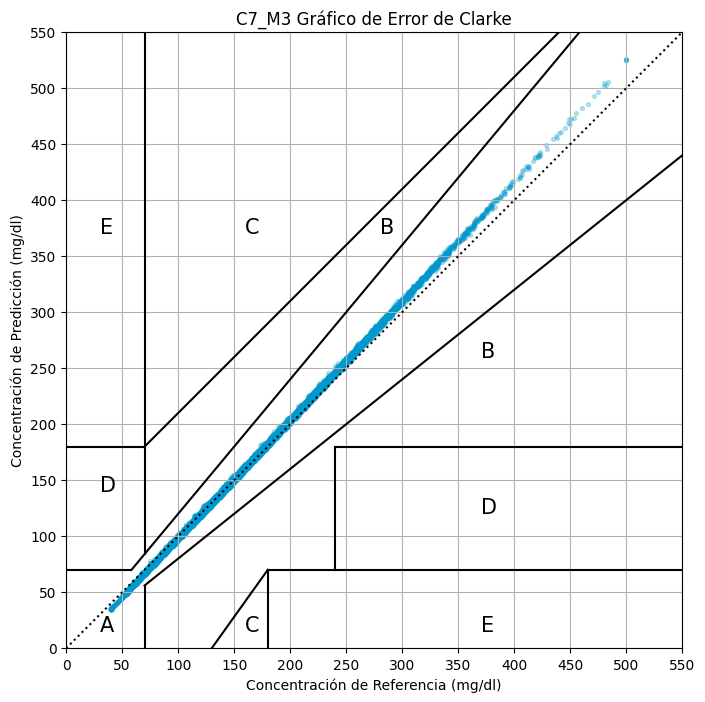

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070





===== Caso8 =====
Variables usadas: ['Month', 'Day', 'Weekday', 'Daytime', 'Trend', 'Diagnostic', 'Difference']
Creando conjuntos de Entrenamiento, Validación y Test
Shape of sequences after split:  (210696, 12, 8)
Shape of labels after split:  (210696,)
[[0.4545454545454545, 0.26666666666666666, 0.16666666666666666, 0.6666666666666666, 0.5, 0.5, 0.5, 0.1282608695652174], [0.4545454545454545, 0.26666666666666666, 0.16666666666666666, 0.6666666666666666, 0.0, 0.5, 0.48267326732673266, 0.11304347826086958], [0.4545454545454545, 0.26666666666666666, 0.166666666

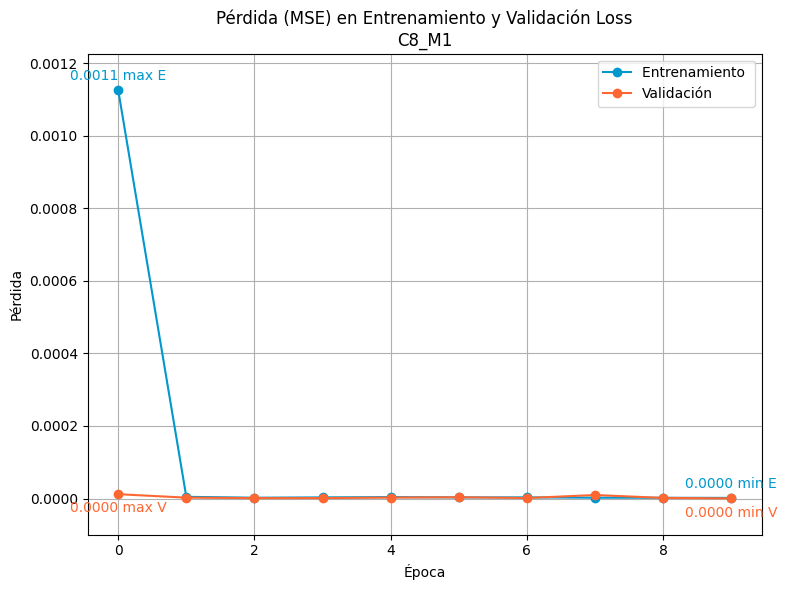


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 2.6484e-07
Pérdida (MSE) : 2.6483678539079847e-07
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.05603931811542185
Error Absoluto Medio (MAE): 0.18689731929219514
Puntuación R^2: 0.9999865463836645


<Figure size 640x480 with 0 Axes>

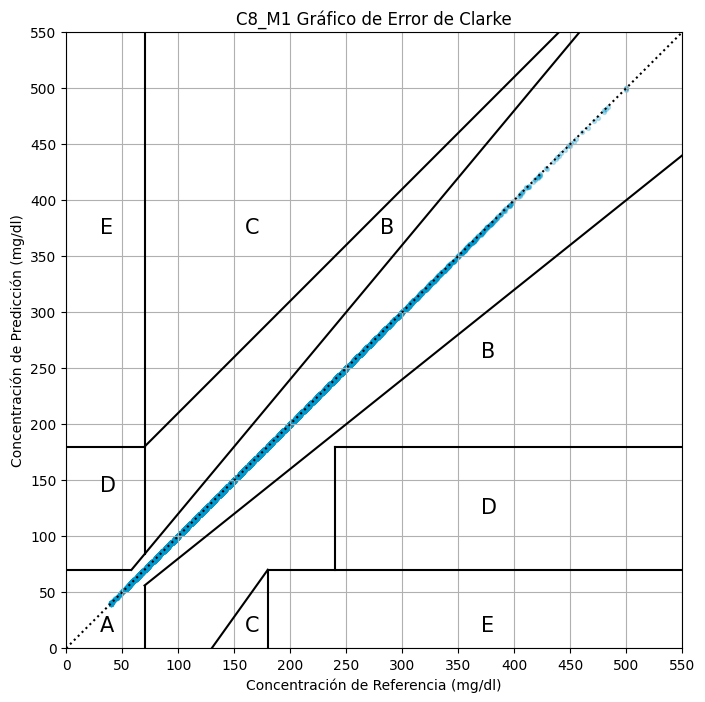

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
==== Segundo modelo (C8_M2) ====
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_29 (CuDNNLSTM)   (None, 12, 256)           272384    
                                                                 
 dropout_56 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_30 (CuDNNLSTM)   (None, 128)               197632    
                                                   

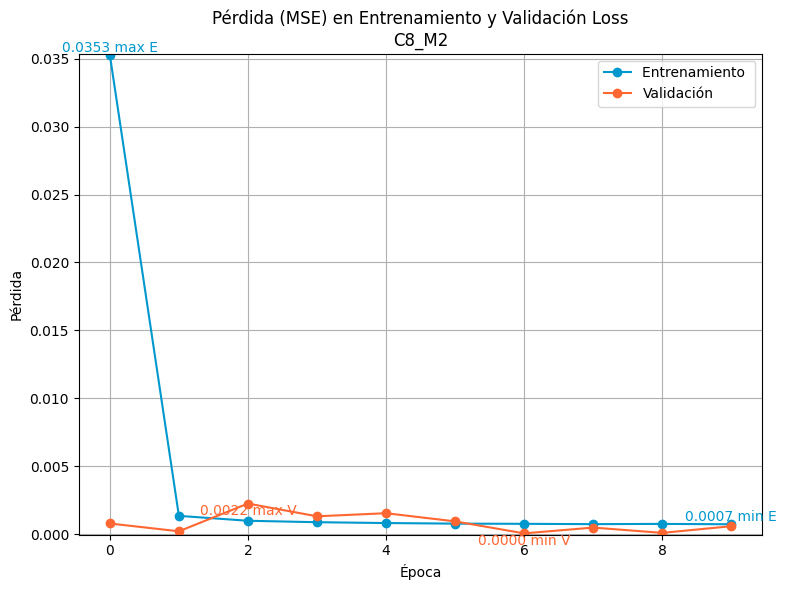


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 5.6494e-04
Pérdida (MSE) : 0.0005649391678161919
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 119.54111016176165
Error Absoluto Medio (MAE): 8.278479237097047
Puntuación R^2: 0.971301216957669


<Figure size 640x480 with 0 Axes>

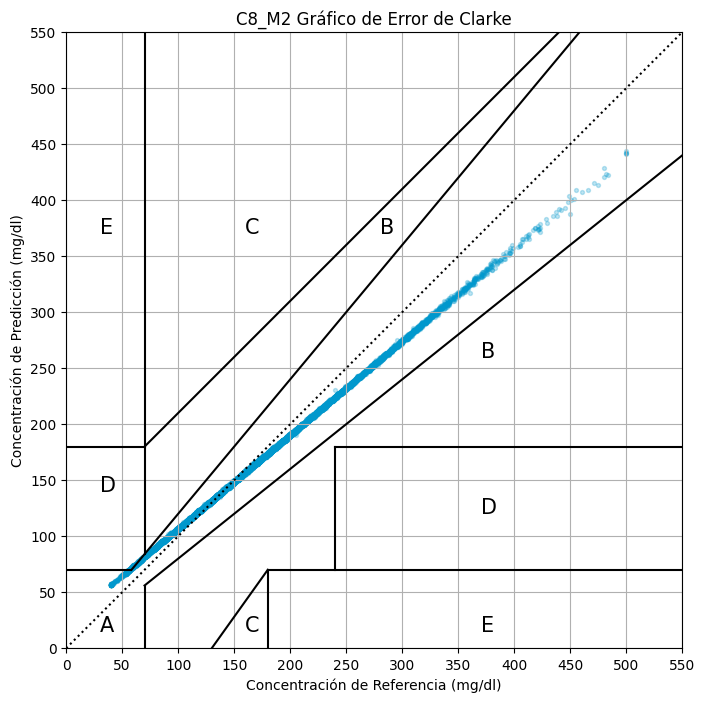

Región A: 20859 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 211 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_31 (CuDNNLSTM)   (None, 128)               70656     
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 256)               33024     
                                                                 
 batch_normaliza

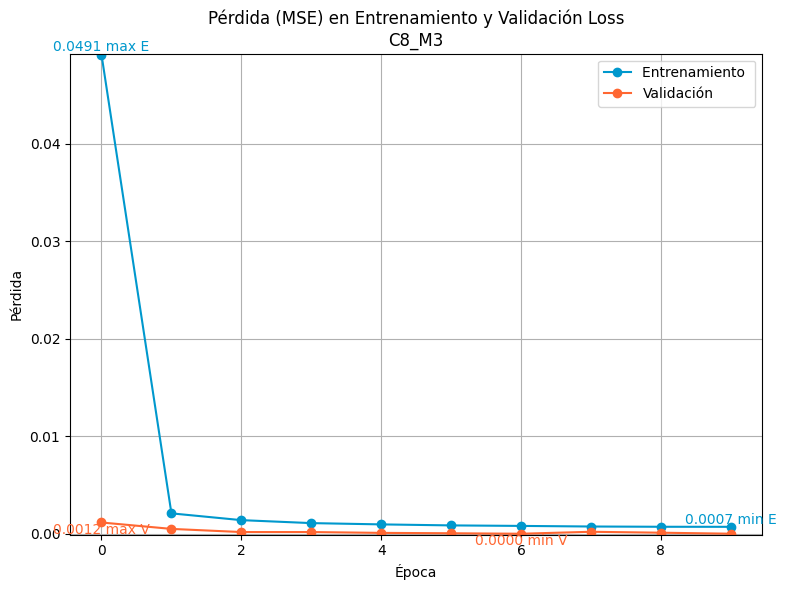


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 2.2365e-05
Pérdida (MSE) : 2.236471846117638e-05
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 4.7323779822505765
Error Absoluto Medio (MAE): 1.7311094779225944
Puntuación R^2: 0.9988638762949154


<Figure size 640x480 with 0 Axes>

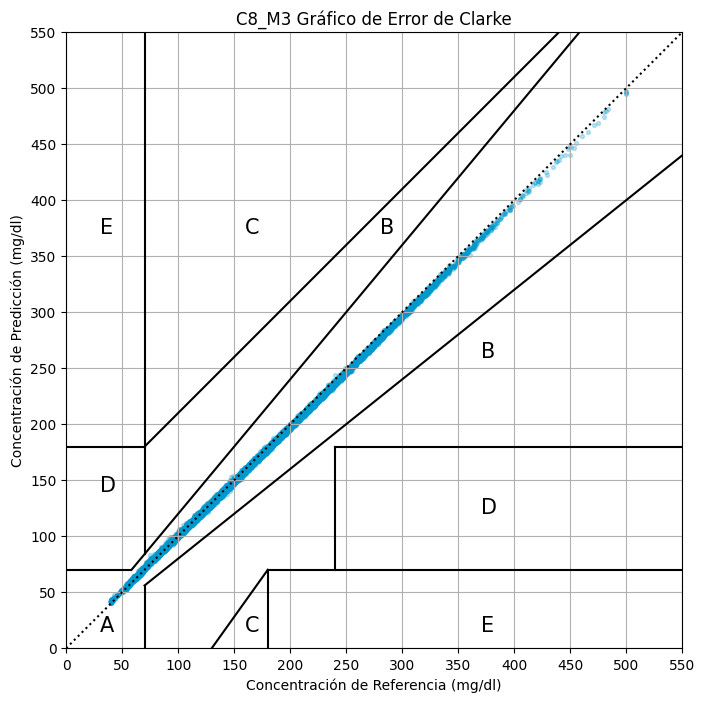

Región A: 21070 puntos dentro del 20% del sensor de referencia
Región B: 0 puntos fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos que indican un tratamiento innecesario
Región D: 0 puntos que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


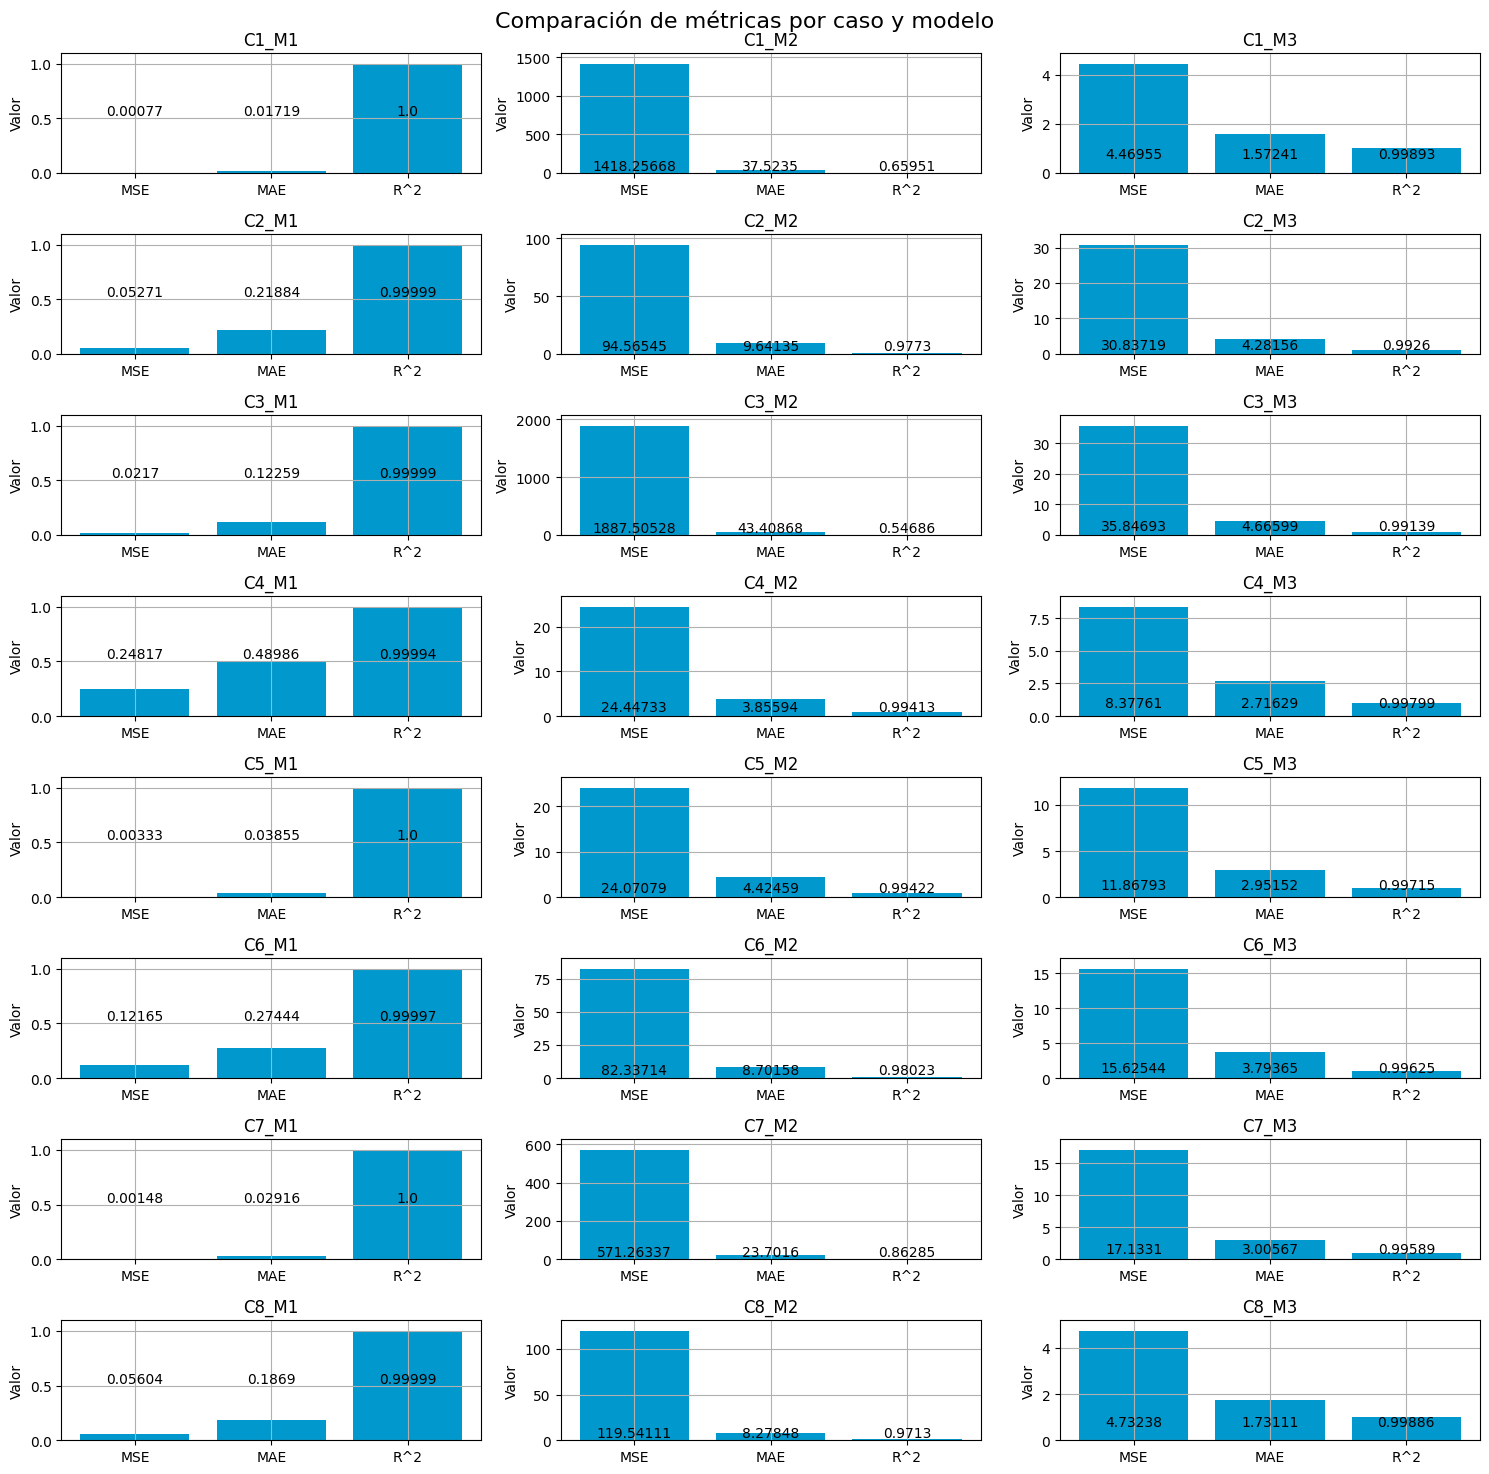

In [18]:
cases_summary = {
    'Caso1':[['Measurement']],
    'Caso2':[['Month','Day']],
    'Caso3':[['Weekday']],
    'Caso4':[['Hour','Minute']],
    'Caso5':[['Daytime']],
    'Caso6':[['Trend','Diagnostic']],
    'Caso7':[['Difference']],
    'Caso8':[['Month','Day','Weekday','Daytime','Trend','Diagnostic','Difference']]
}

if not os.path.exists(TIME_SERIES_PATH):
    df_glucose = pd.read_csv('Glucose_measurements_sample.csv')
    measurementsPerPatient(df_glucose)
    monthlyMeasurement(df_glucose)
    monthlyMeasurementPerYear(df_glucose)    
    plotCorrelation(df_glucose,INITIAL_COLUMNS, "inicial")
    df_glucose = addAdditionalVariables(df_glucose)    
    weekdayMeasurement(df_glucose)
    daytimeMeasurement(df_glucose)
    plotCorrelation(df_glucose,FINAL_COLUMNS, "final")
    time_series = createTemporalSeries(df_glucose)
    time_series.to_csv(TIME_SERIES_PATH)
else:
    time_series = pd.read_csv(TIME_SERIES_PATH)
    

cases_summary = runCases(time_series,cases_summary)
plotMetricsAnalisys()